## Surprise Housing- House Price Prediction using Linear, Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

### 1. Data Understanding and Exploration

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [178]:
# reading the dataset
house = pd.read_csv("train.csv")

In [179]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [180]:
#checking for null entries
print((house.isnull().sum() > 0).sum())

19


In [181]:
#checking for columns which has more than 85% of data being NULL
for i in house.columns:
    null_perc = round(100*(house[i].isnull().sum()/len(house.index)), 2)
    if null_perc > 80:
        print(i,null_perc)

Alley 93.77
PoolQC 99.52
Fence 80.75
MiscFeature 96.3


In [182]:
house['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [183]:
house['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [184]:
house['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [185]:
house['Fence'].value_counts() 

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [186]:
house_cat = house.select_dtypes(include=['object'])
for i in house_cat:
    print(i,house[i].nunique())

MSZoning 5
Street 2
Alley 2
LotShape 4
LandContour 4
Utilities 2
LotConfig 5
LandSlope 3
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 15
Exterior2nd 16
MasVnrType 4
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 4
BsmtCond 4
BsmtExposure 4
BsmtFinType1 6
BsmtFinType2 6
Heating 6
HeatingQC 5
CentralAir 2
Electrical 5
KitchenQual 4
Functional 7
FireplaceQu 5
GarageType 6
GarageFinish 3
GarageQual 5
GarageCond 5
PavedDrive 3
PoolQC 3
Fence 4
MiscFeature 4
SaleType 9
SaleCondition 6


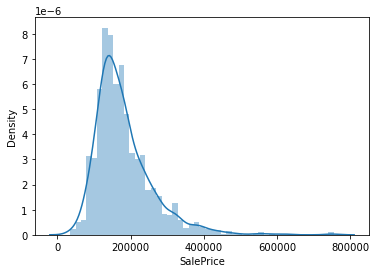

In [187]:
# target variable: sale price of house
sns.distplot(house['SalePrice'])
plt.show()

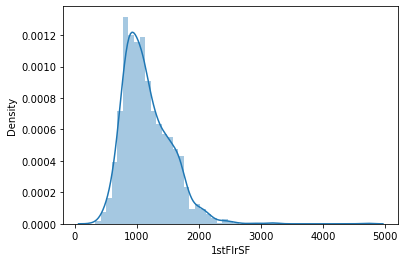

In [188]:
sns.distplot(house['1stFlrSF'])
plt.show()

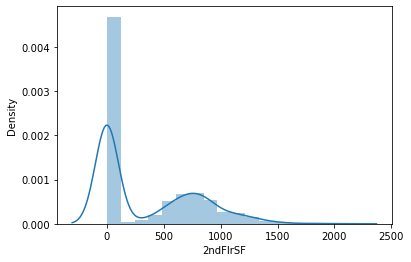

In [189]:
sns.distplot(house['2ndFlrSF'])
plt.show()

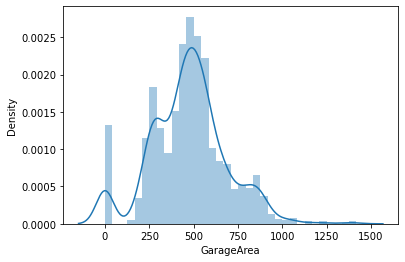

In [190]:
sns.distplot(house['GarageArea'])
plt.show()

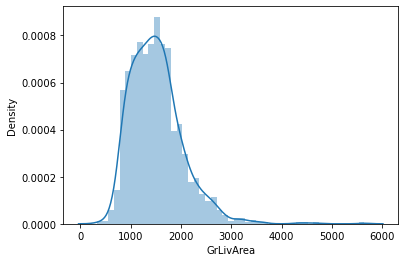

In [191]:
sns.distplot(house['GrLivArea'])
plt.show()

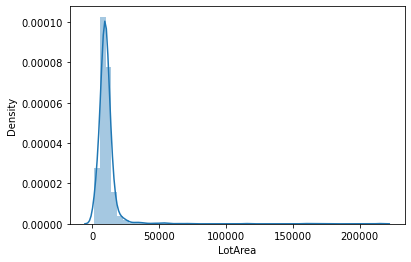

In [192]:
sns.distplot(house['LotArea'])
plt.show()

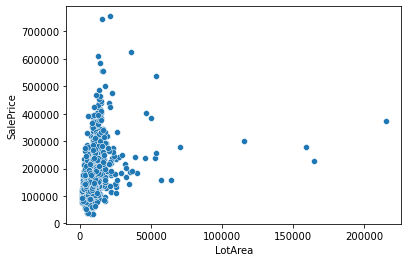

In [193]:
sns.scatterplot(data=house,x=house['LotArea'],y=house['SalePrice'])
plt.show()

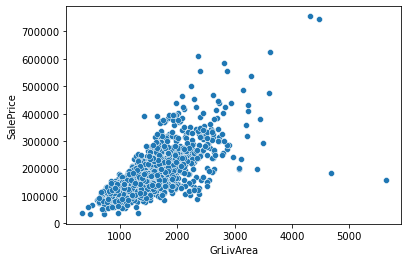

In [194]:
sns.scatterplot(data=house,x=house['GrLivArea'],y=house['SalePrice'])
plt.show()

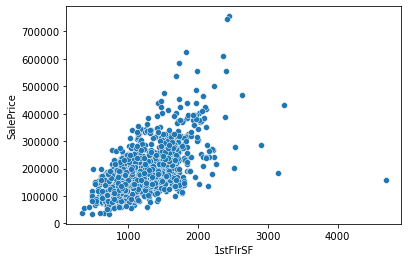

In [195]:
sns.scatterplot(data=house,x=house['1stFlrSF'],y=house['SalePrice'])
plt.show()

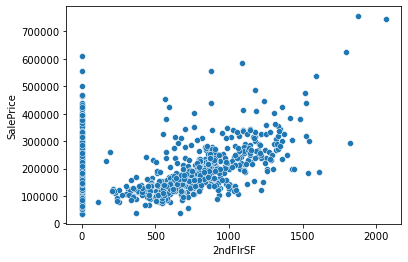

In [196]:
sns.scatterplot(data=house,x=house['2ndFlrSF'],y=house['SalePrice'])
plt.show()

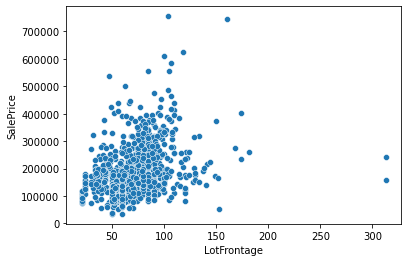

In [197]:
sns.scatterplot(data=house,x=house['LotFrontage'],y=house['SalePrice'])
plt.show()

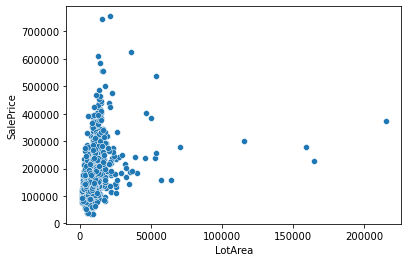

In [198]:
sns.scatterplot(data=house,x=house['LotArea'],y=house['SalePrice'])
plt.show()

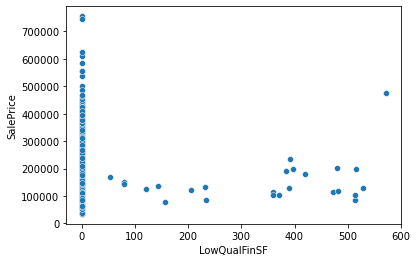

In [199]:
sns.scatterplot(data=house,x=house['LowQualFinSF'],y=house['SalePrice'])
plt.show()

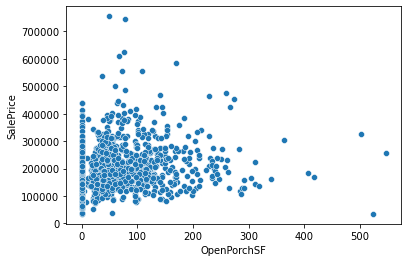

In [200]:
sns.scatterplot(data=house,x=house['OpenPorchSF'],y=house['SalePrice'])
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [201]:
# all numeric (float and int) variables in the dataset
house_numeric = house.select_dtypes(include=['float64', 'int64'])
house_numeric.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  OpenPorchSF  \
0          2003       196.0         706  ...           0           61   
1          1976         0.0         978  ...         298            0   
2          2002       162.0         486  ...           0           42   
3          1970         0.0         216  ...           0           35   
4          2000       350.0         655  ...         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000  

[5 rows x 38 columns]

In [202]:
house['PoolArea'].value_counts() 

0      1453
480       1
512       1
519       1
555       1
576       1
648       1
738       1
Name: PoolArea, dtype: int64

In [203]:
house = house.drop(['Id','MoSold','YrSold'], axis=1)
house.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... 3SsnPorch ScreenPorch PoolArea PoolQC  \
0         Lvl    AllPub    Inside  ...         0           0        0    NaN   
1         Lvl    AllPub       FR2  ...         0           0        0    NaN   
2         Lvl    AllPub    Inside  ...         0           0        0    NaN   
3         Lvl    AllPub    Corner  ...         0           0        0    NaN   
4         Lvl    AllPub       FR2  ...         0           0        0    NaN   

  Fence MiscFeature  MiscVal  SaleType  SaleCondition  SalePrice  
0   NaN         NaN        0        WD         Normal     208500  
1   NaN         NaN        0        WD         Normal     181500  
2   NaN         NaN        0        WD         Normal     223500  
3   NaN         NaN        0        WD        Abnorml     140000  
4   NaN         NaN        0        WD         Normal     250000  

[5 rows x 78 columns]

In [204]:
# dropping ID, MoSold, YrSold as ID not needed and month and year when house was sold will not be available for new houses.
house_numeric = house_numeric.drop(['Id','MoSold','YrSold'], axis=1)
house_numeric.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageCars  \
0          2003       196.0         706           0  ...           2   
1          1976         0.0         978           0  ...           2   
2          2002       162.0         486           0  ...           2   
3          1970         0.0         216           0  ...           3   
4          2000       350.0         655           0  ...           3   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0         548           0           61              0          0            0   
1         460         298            0              0          0            0   
2         608           0           42              0          0            0   
3         642           0           35            272          0            0   
4         836         192           84              0          0            0   

   PoolArea  MiscVal  SalePrice  
0         0        0     208500  
1         0        0     181500  
2         0        0     223500  
3         0        0     140000  
4         0        0     250000  

[5 rows x 35 columns]

In [205]:
house_cat = house_numeric.select_dtypes(include=['float64', 'int64'])
for i in house_cat:
    print(i,house[i].nunique())

MSSubClass 15
LotFrontage 110
LotArea 1073
OverallQual 10
OverallCond 9
YearBuilt 112
YearRemodAdd 61
MasVnrArea 327
BsmtFinSF1 637
BsmtFinSF2 144
BsmtUnfSF 780
TotalBsmtSF 721
1stFlrSF 753
2ndFlrSF 417
LowQualFinSF 24
GrLivArea 861
BsmtFullBath 4
BsmtHalfBath 3
FullBath 4
HalfBath 3
BedroomAbvGr 8
KitchenAbvGr 4
TotRmsAbvGrd 12
Fireplaces 4
GarageYrBlt 97
GarageCars 5
GarageArea 441
WoodDeckSF 274
OpenPorchSF 202
EnclosedPorch 120
3SsnPorch 20
ScreenPorch 76
PoolArea 8
MiscVal 21
SalePrice 663


In [206]:
house['GarageCars'].value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [207]:
# dropping all the numeric variables which are actually categorical. These variables needs to be convereted to needed dummies
house_numeric = house_numeric.drop(['MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd'], axis=1)
house_numeric.head()

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0         65.0     8450       196.0         706           0        150   
1         80.0     9600         0.0         978           0        284   
2         68.0    11250       162.0         486           0        434   
3         60.0     9550         0.0         216           0        540   
4         84.0    14260       350.0         655           0        490   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  ...  GarageCars  GarageArea  \
0          856       856       854             0  ...           2         548   
1         1262      1262         0             0  ...           2         460   
2          920       920       866             0  ...           2         608   
3          756       961       756             0  ...           3         642   
4         1145      1145      1053             0  ...           3         836   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0           0           61              0          0            0         0   
1         298            0              0          0            0         0   
2           0           42              0          0            0         0   
3           0           35            272          0            0         0   
4         192           84              0          0            0         0   

   MiscVal  SalePrice  
0        0     208500  
1        0     181500  
2        0     223500  
3        0     140000  
4        0     250000  

[5 rows x 30 columns]

               LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
LotFrontage       1.000000  0.426095    0.193458    0.233633    0.049900   
LotArea           0.426095  1.000000    0.104160    0.214103    0.111170   
MasVnrArea        0.193458  0.104160    1.000000    0.264736   -0.072319   
BsmtFinSF1        0.233633  0.214103    0.264736    1.000000   -0.050117   
BsmtFinSF2        0.049900  0.111170   -0.072319   -0.050117    1.000000   
BsmtUnfSF         0.132644 -0.002618    0.114442   -0.495251   -0.209294   
TotalBsmtSF       0.392075  0.260833    0.363936    0.522396    0.104810   
1stFlrSF          0.457181  0.299475    0.344501    0.445863    0.097117   
2ndFlrSF          0.080177  0.050986    0.174561   -0.137079   -0.099260   
LowQualFinSF      0.038469  0.004779   -0.069071   -0.064503    0.014807   
GrLivArea         0.402797  0.263116    0.390857    0.208171   -0.009640   
BsmtFullBath      0.100949  0.158155    0.085310    0.649212    0.158678   
BsmtHalfBath

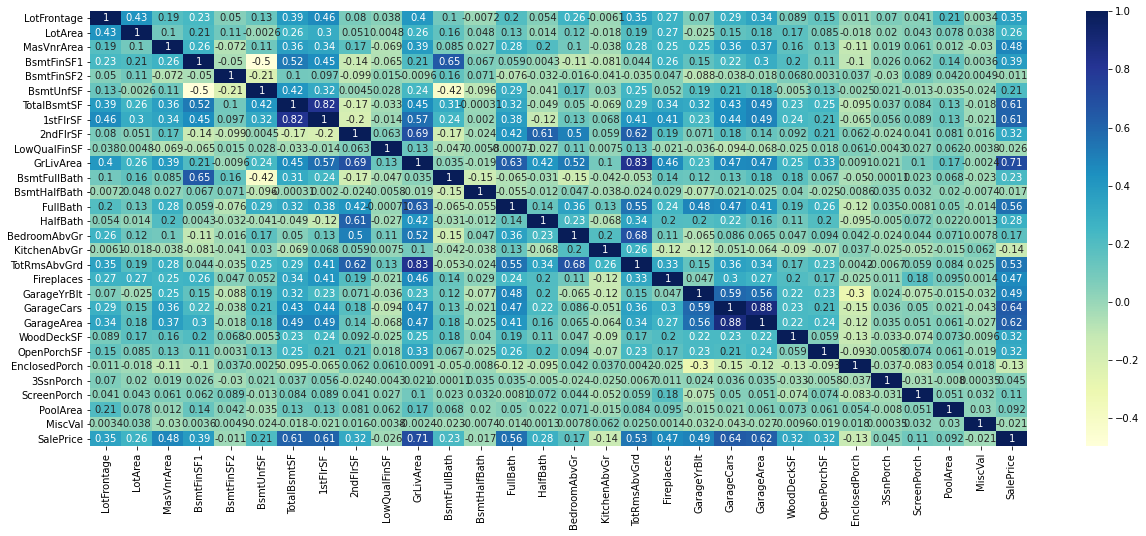

In [208]:
corr= house_numeric.corr()
print(corr)
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(21,8))

# heatmap
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

The heatmap shows some useful insights:

Correlation of Saleprice with independent variables:
- Price is highly (positively) correlated with GrlivArea, TotalBsmtSF, 1stFlrSF,GarageCars,GarageArea. these variables defines the luxury of the house due to which, when thse indendependent variables increases, saleprice tends to be increase.


Correlation among independent variables:
- Many independent variables are highly correlated : Garagecars and garageArea , totalbsnmtSF and  1stFlrSF etc..


# More Bivariate analysis to understand the relationship with response variable:

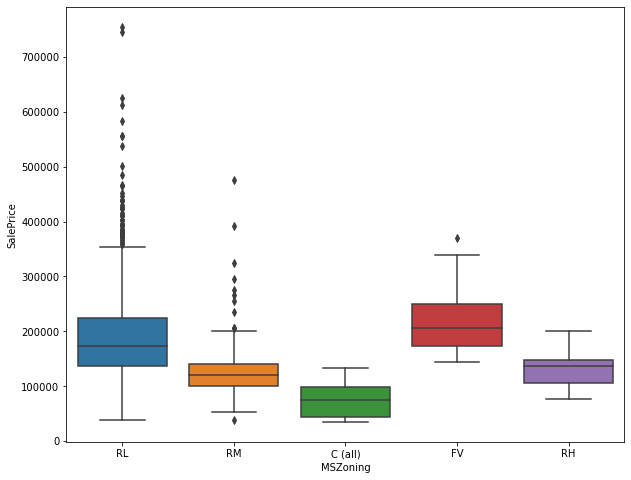

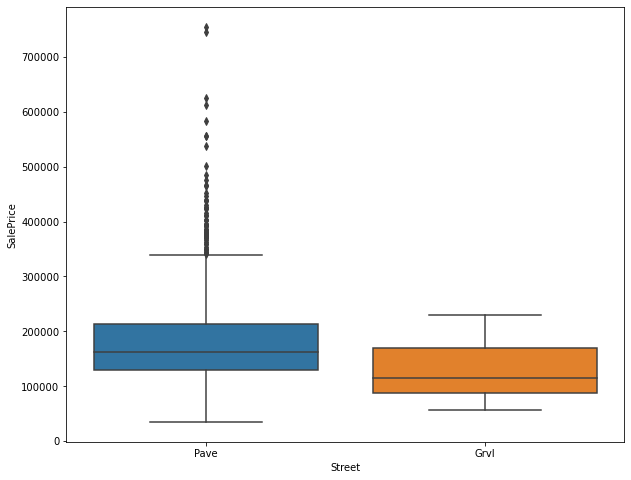

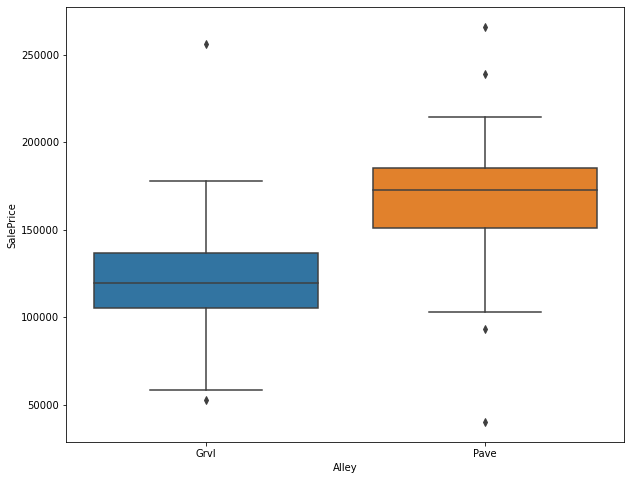

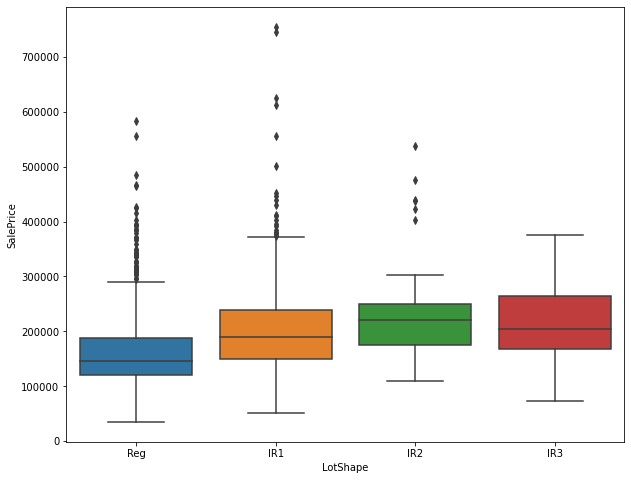

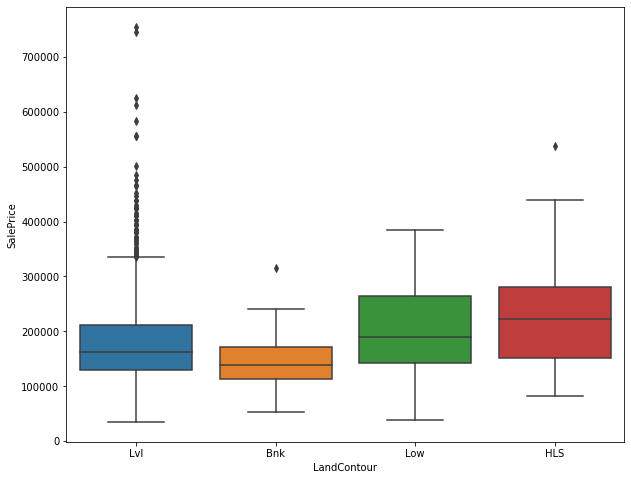

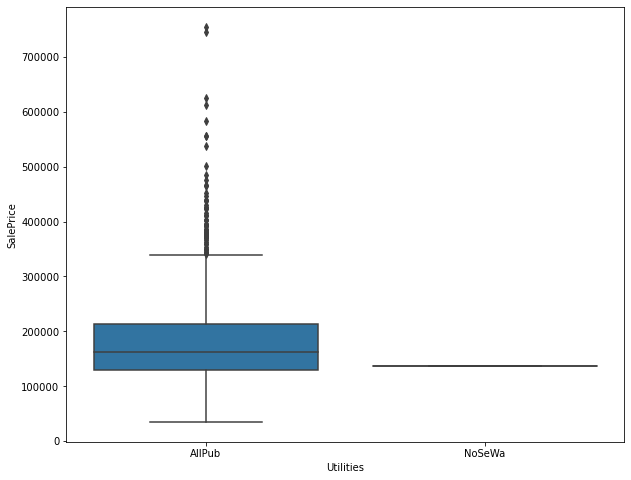

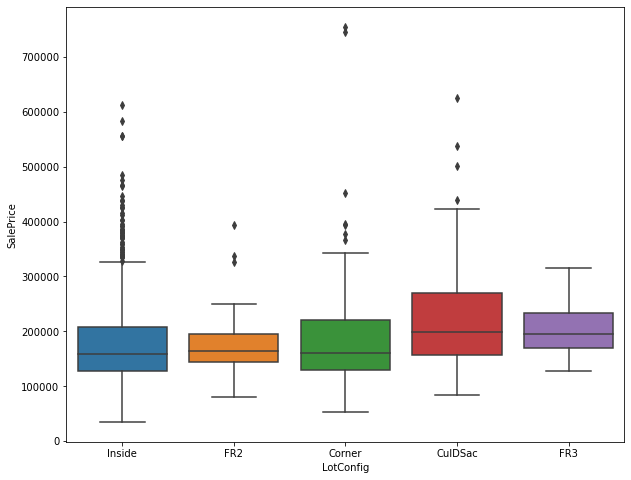

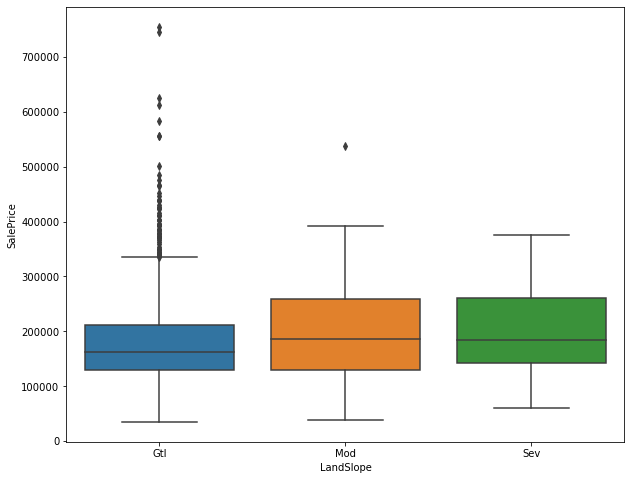

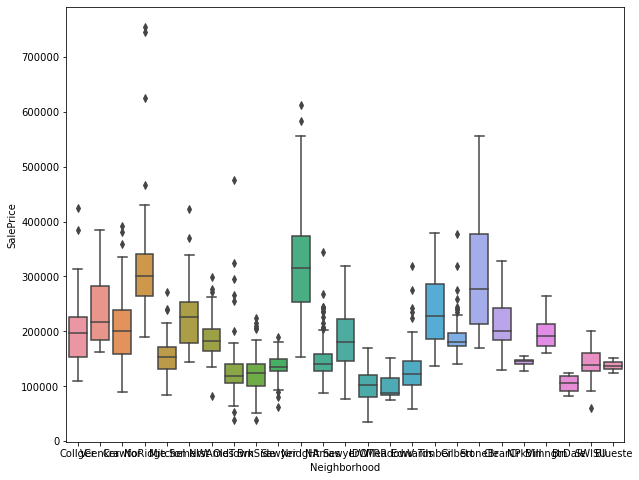

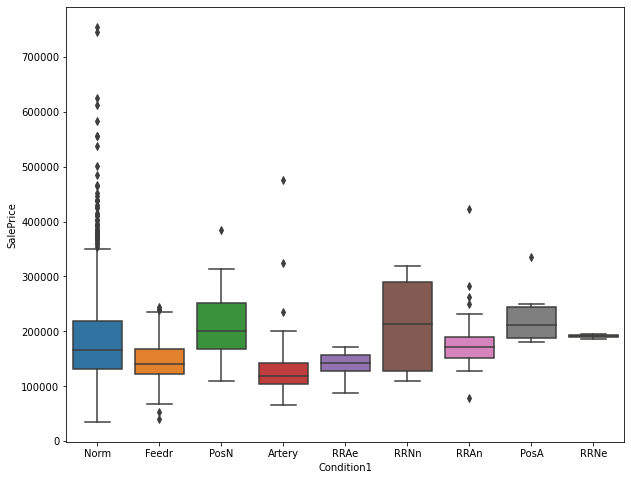

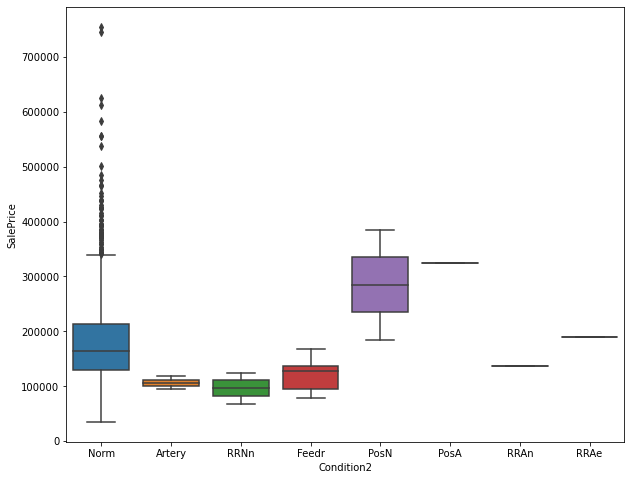

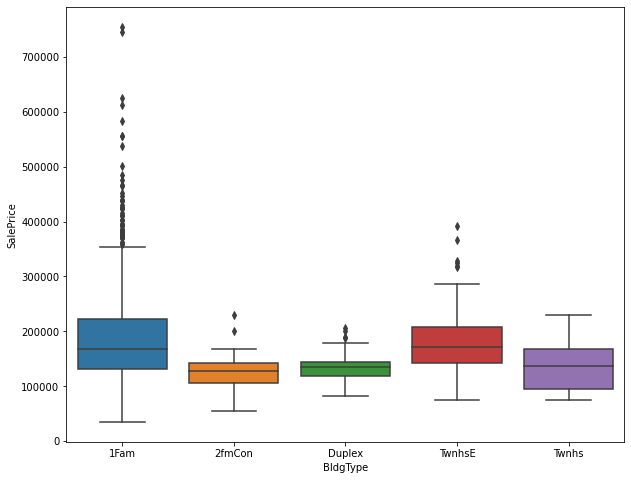

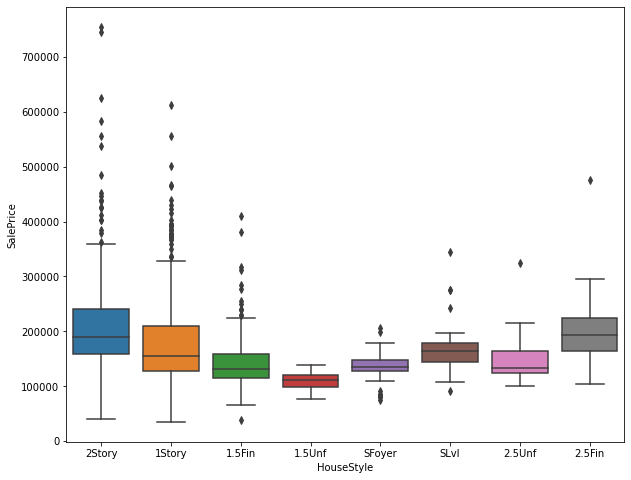

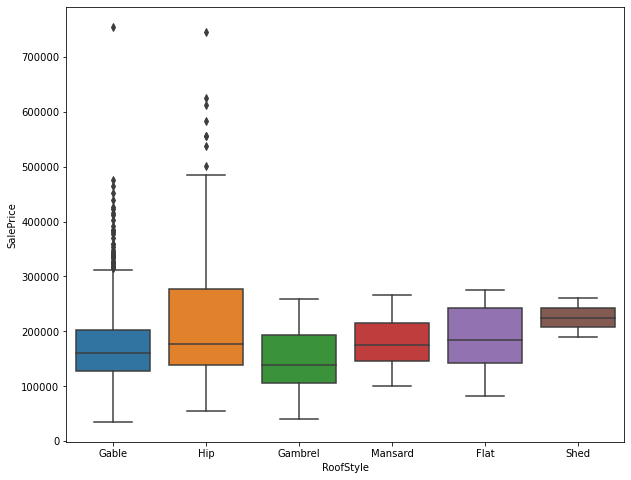

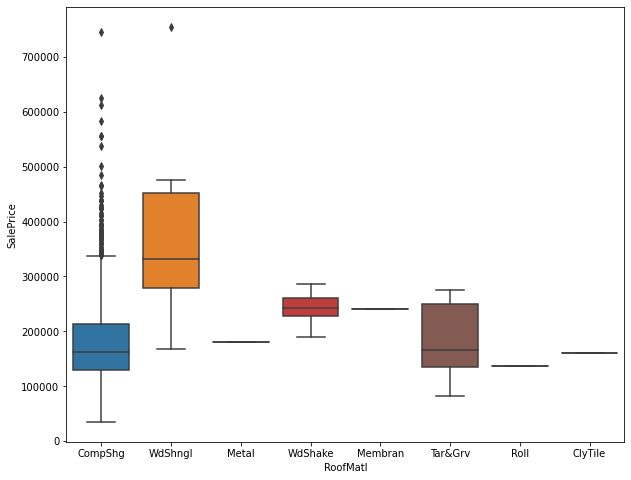

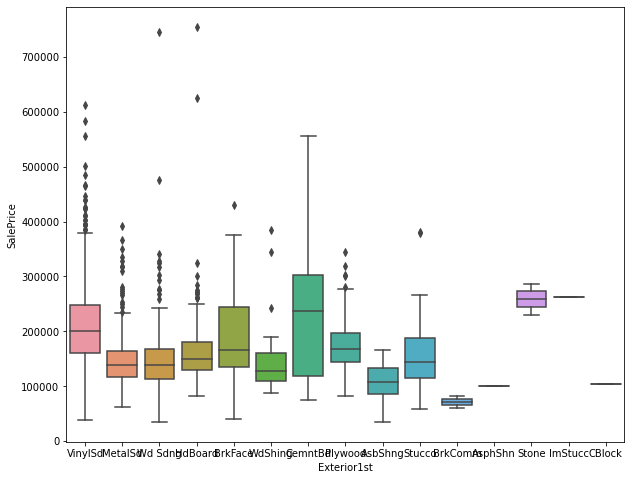

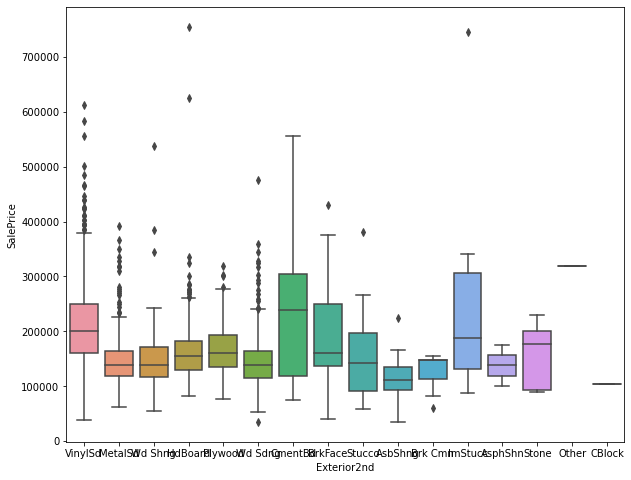

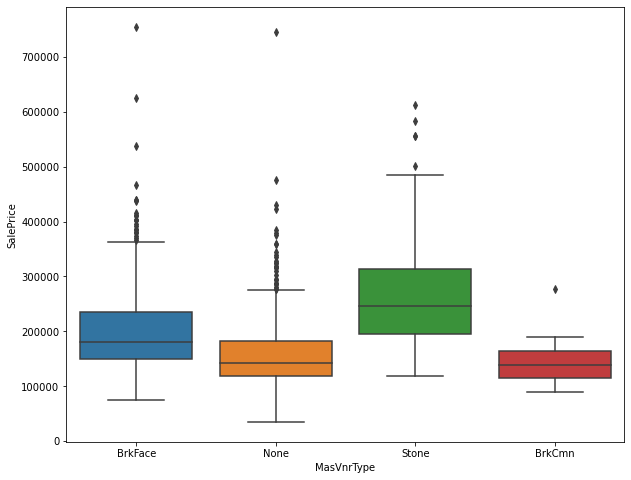

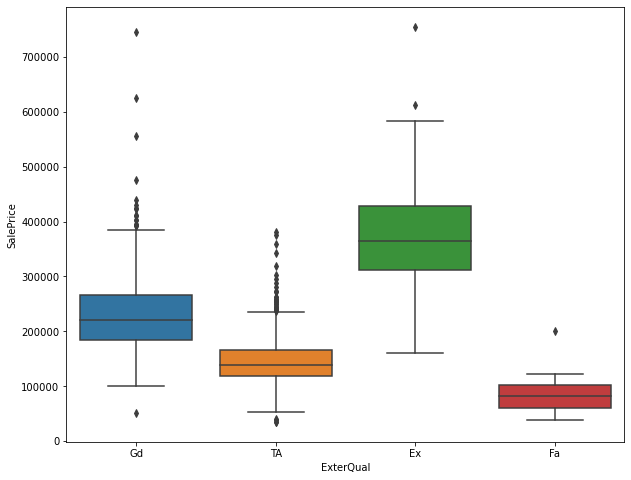

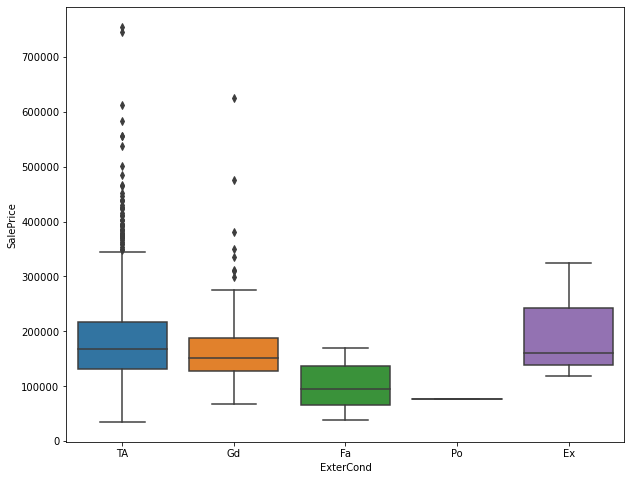

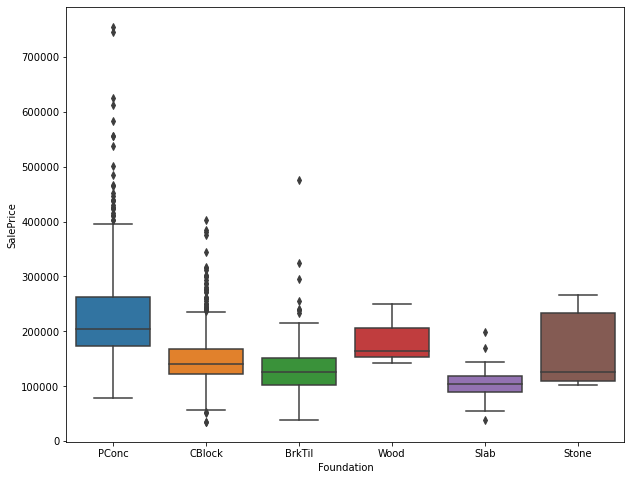

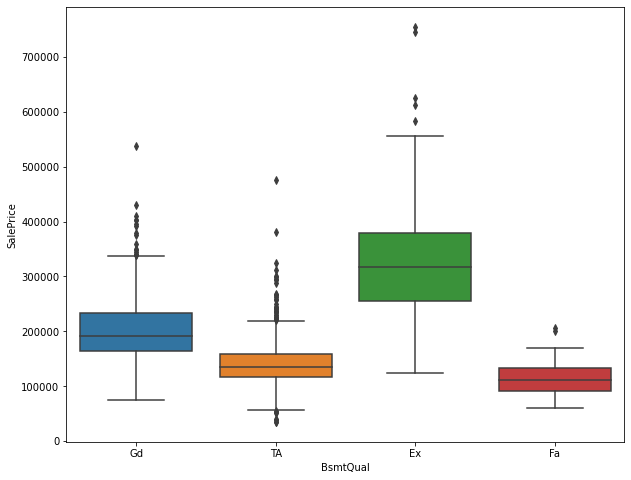

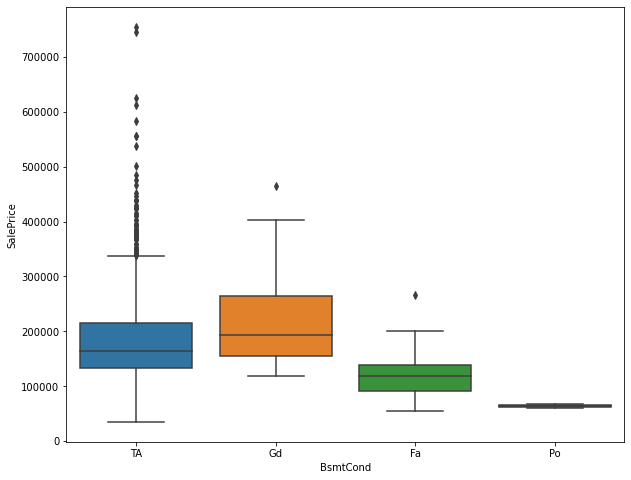

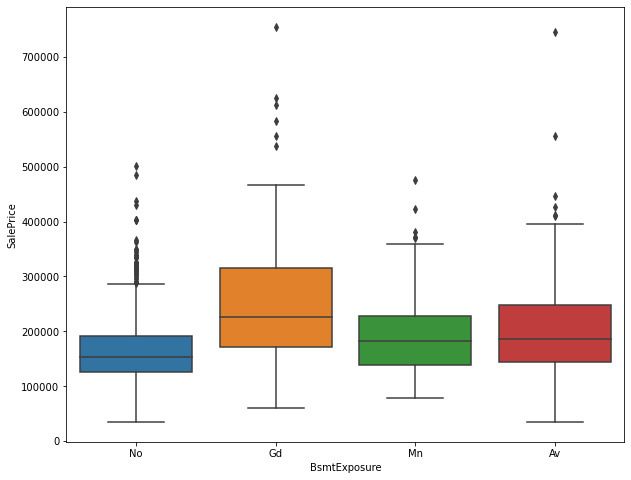

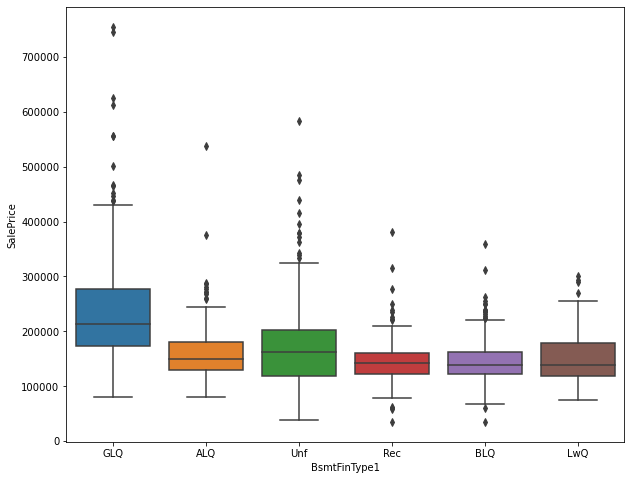

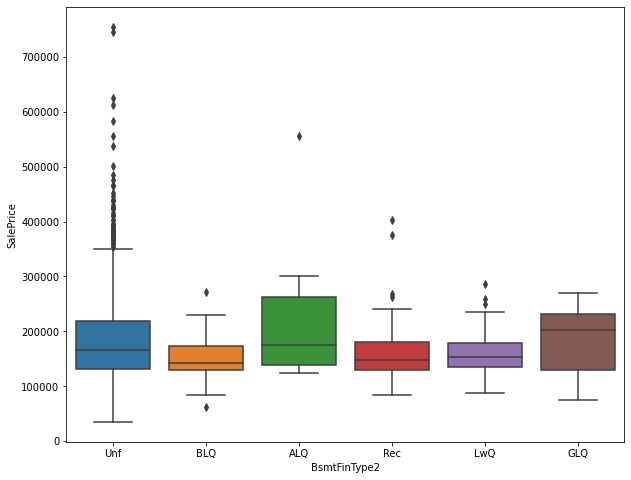

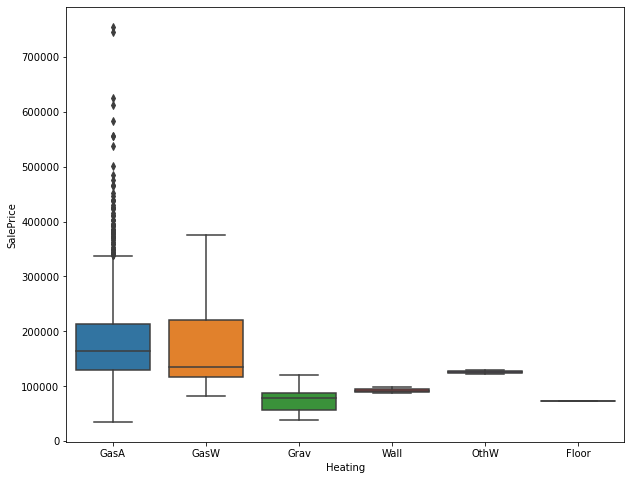

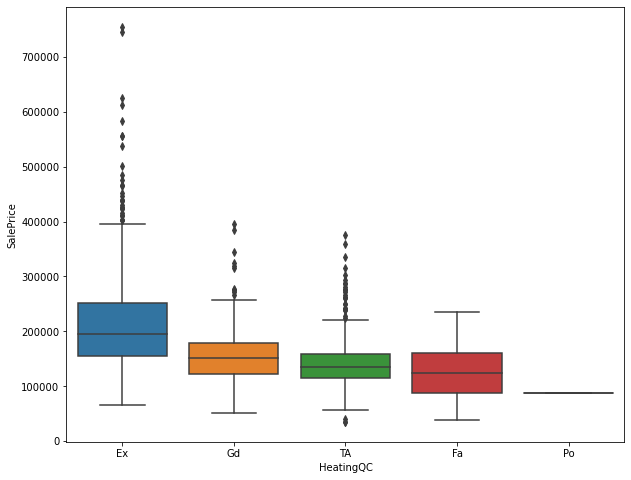

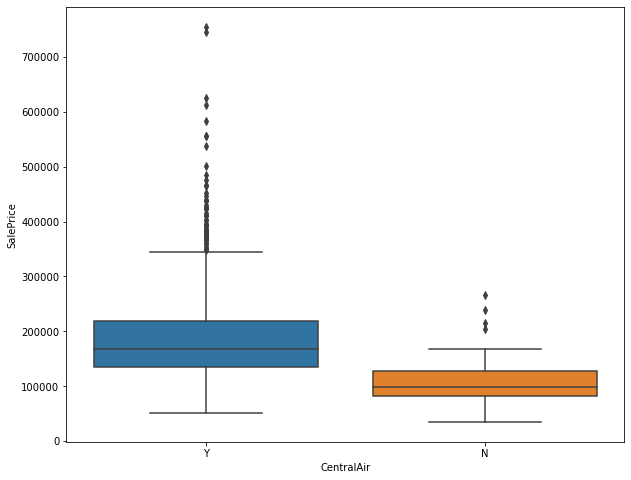

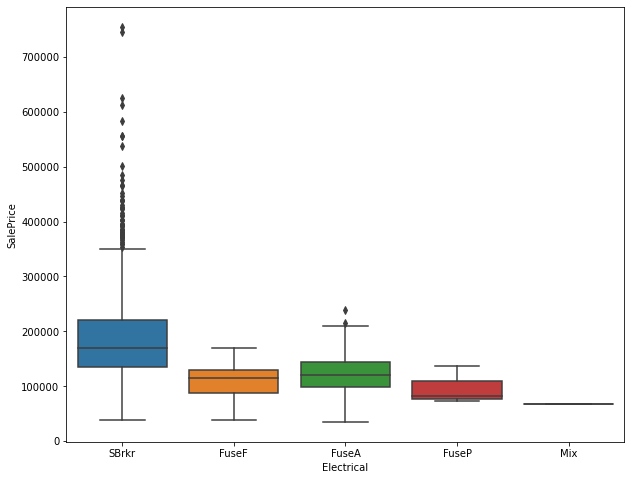

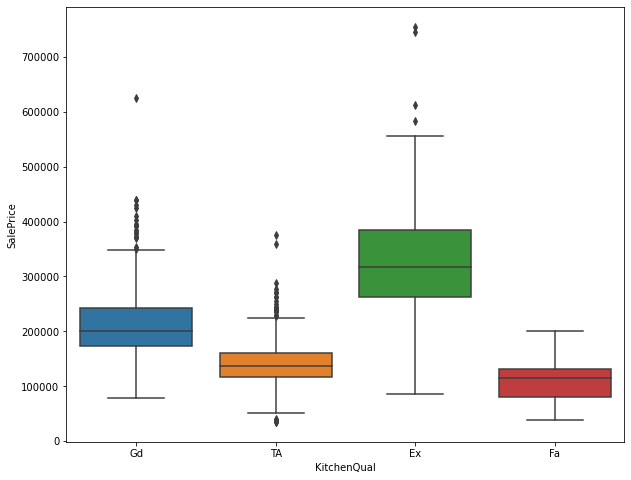

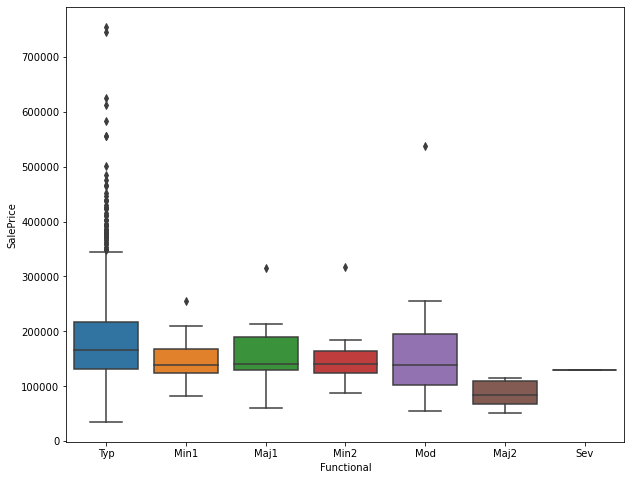

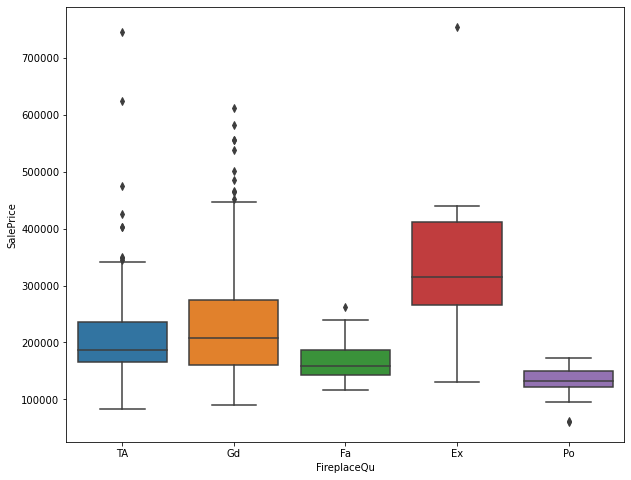

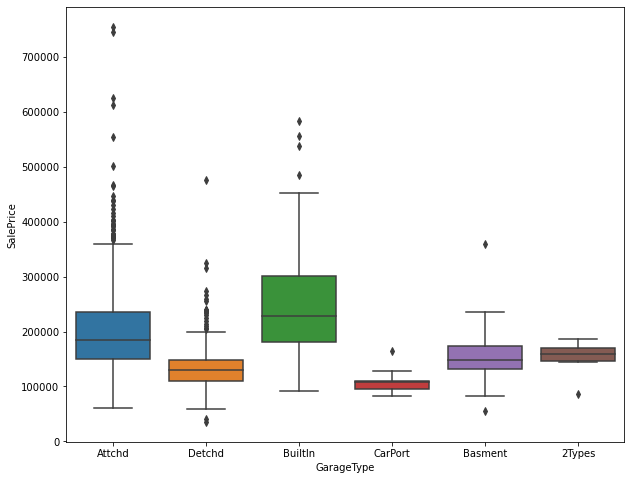

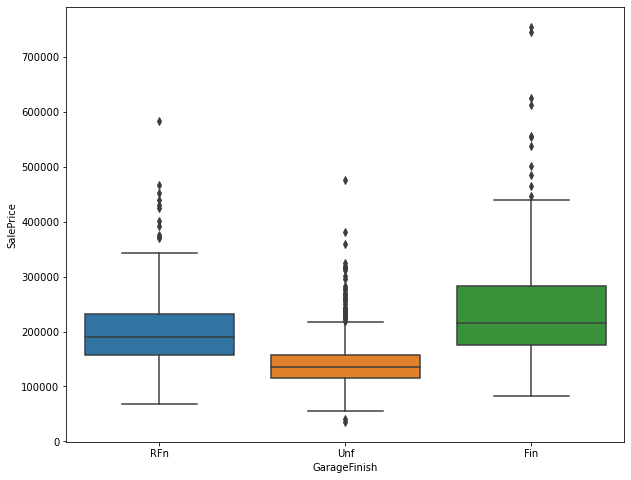

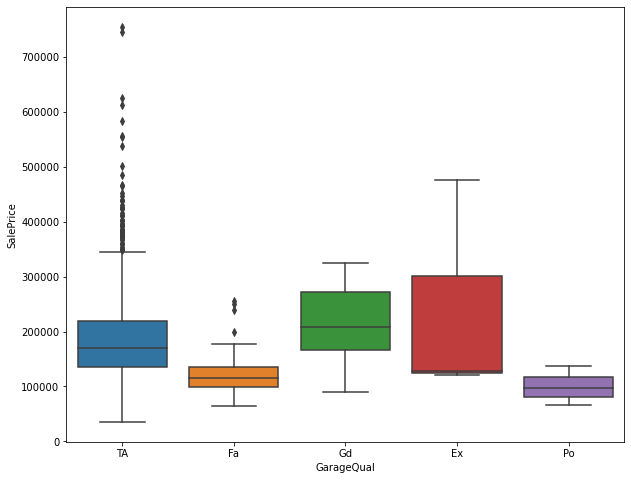

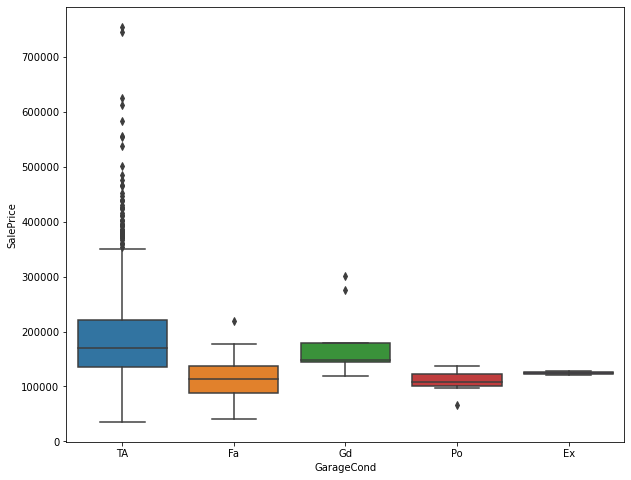

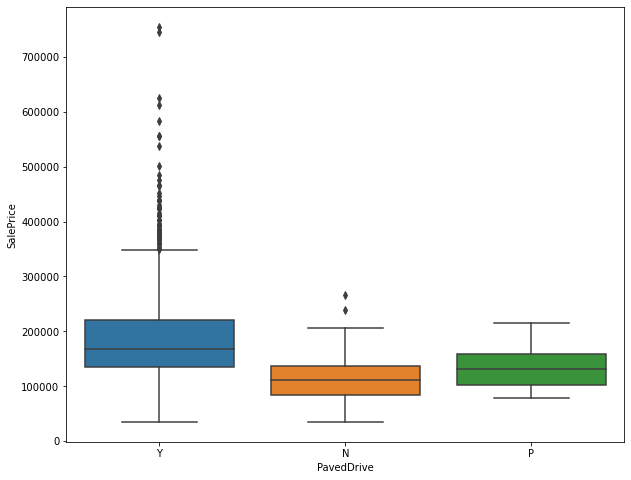

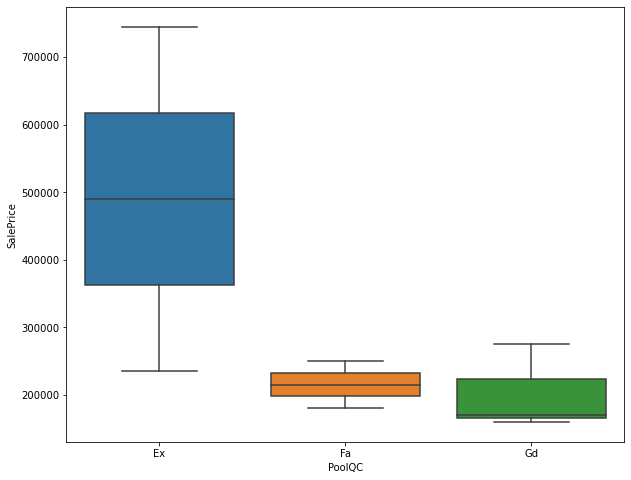

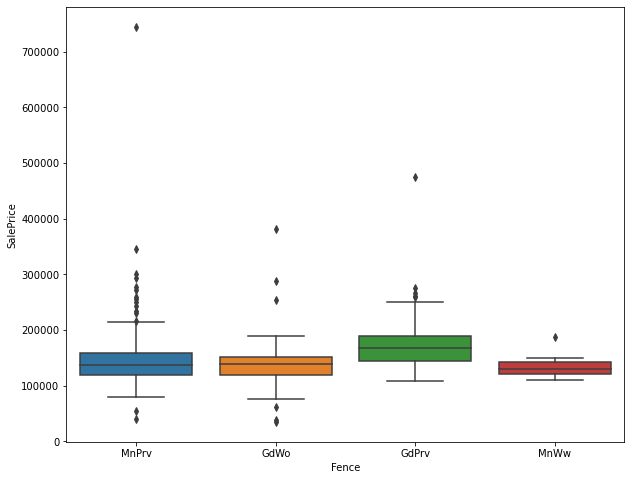

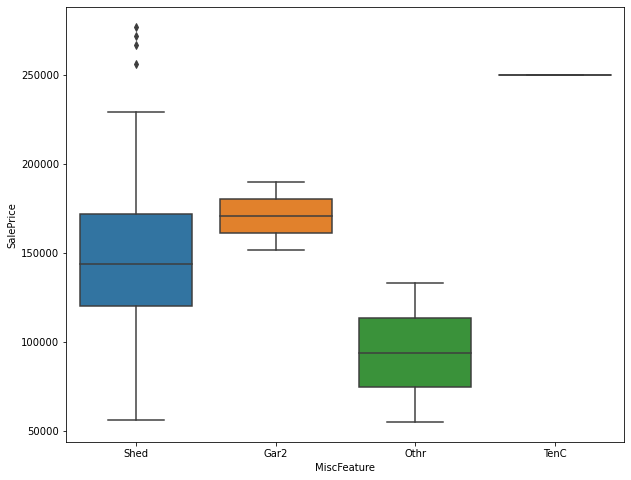

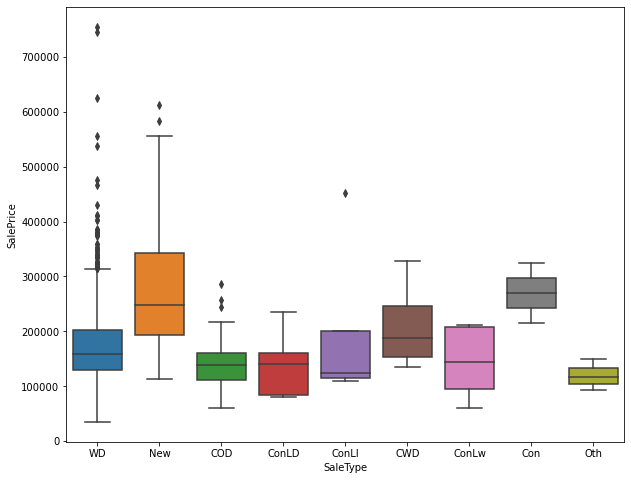

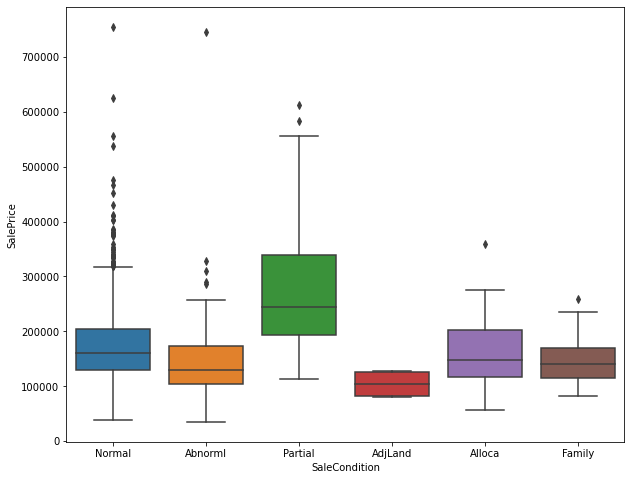

In [209]:
house_cat_vars = house.select_dtypes(include=['object'])
for i in house_cat_vars:
    plt.figure(figsize=(10,8))
    sns.boxplot(data=house,x=house[i],y=house['SalePrice'])
    plt.show()

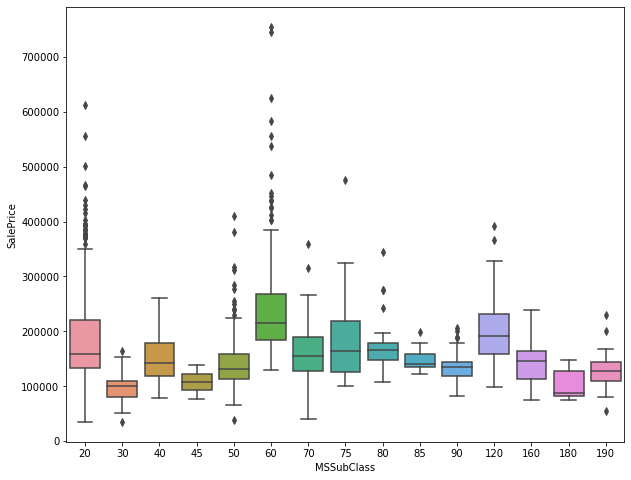

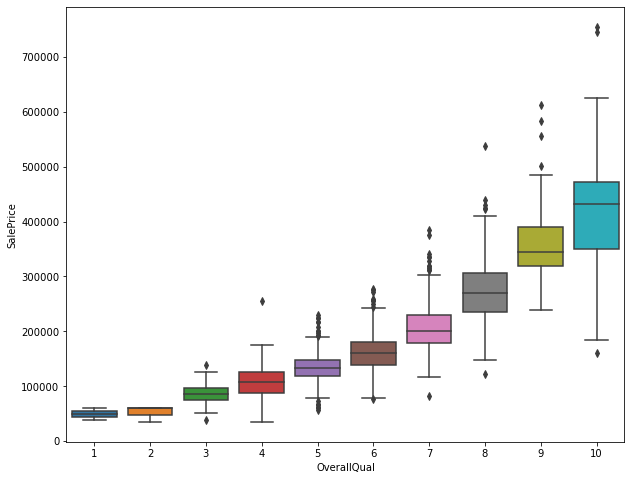

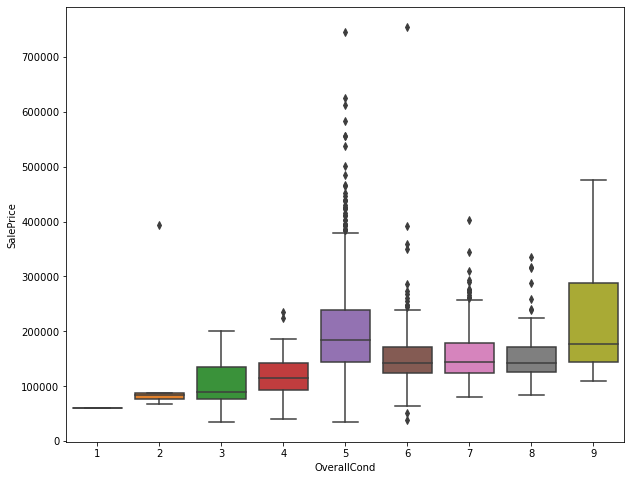

In [210]:
house_cat_vars_from_cont = house[['MSSubClass','OverallQual','OverallCond']]
for i in house_cat_vars_from_cont:
    plt.figure(figsize=(10,8))
    sns.boxplot(data=house,x=house[i],y=house['SalePrice'])
    plt.show()

## 2. Data Cleaning

Let's now conduct some data cleaning steps. 

We've seen that there are some missing values like LotFrontage,GarageQual etc. We've also seen that variables needs to be converted to categorical variables (so that dummy variable are created for the categories).



In [211]:
for i in house.columns:
    null_perc = round(100*(house[i].isnull().sum()/len(house.index)), 2)
    if null_perc > 0 and null_perc < 80:
        print(i,null_perc)

LotFrontage 17.74
MasVnrType 0.55
MasVnrArea 0.55
BsmtQual 2.53
BsmtCond 2.53
BsmtExposure 2.6
BsmtFinType1 2.53
BsmtFinType2 2.6
Electrical 0.07
FireplaceQu 47.26
GarageType 5.55
GarageYrBlt 5.55
GarageFinish 5.55
GarageQual 5.55
GarageCond 5.55


In [212]:
house['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [213]:
fill_na_vars = ['MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Electrical','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']

In [214]:
for i in fill_na_vars:
    house[i].fillna('NA',inplace=True)

In [215]:
for i in house.columns:
    null_perc = round(100*(house[i].isnull().sum()/len(house.index)), 2)
    if null_perc > 0 and null_perc < 80:
        print(i,null_perc)

LotFrontage 17.74
MasVnrArea 0.55


In [216]:
house['LotFrontage'].fillna(0,inplace=True)

In [217]:
house['MasVnrArea'].fillna(0,inplace=True)

In [218]:
for i in house.columns:
    null_perc = round(100*(house[i].isnull().sum()/len(house.index)), 2)
    if null_perc > 80:
        print(i,null_perc)

Alley 93.77
PoolQC 99.52
Fence 80.75
MiscFeature 96.3


In [219]:
# variables having more than 90% of 
# NULL records can be dropped as most of the records will not have value and cannot be used for analysis

In [220]:
house = house.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1)
house.head()

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   
2          60       RL         68.0    11250   Pave      IR1         Lvl   
3          70       RL         60.0     9550   Pave      IR1         Lvl   
4          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope  ... WoodDeckSF OpenPorchSF EnclosedPorch  \
0    AllPub    Inside       Gtl  ...          0          61             0   
1    AllPub       FR2       Gtl  ...        298           0             0   
2    AllPub    Inside       Gtl  ...          0          42             0   
3    AllPub    Corner       Gtl  ...          0          35           272   
4    AllPub       FR2       Gtl  ...        192          84             0   

  3SsnPorch ScreenPorch  PoolArea  MiscVal  SaleType  SaleCondition SalePrice  
0         0           0         0        0        WD         Normal    208500  
1         0           0         0        0        WD         Normal    181500  
2         0           0         0        0        WD         Normal    223500  
3         0           0         0        0        WD        Abnorml    140000  
4         0           0         0        0        WD         Normal    250000  

[5 rows x 74 columns]

In [221]:
house_numeric['LotFrontage'] = house['LotFrontage']

In [222]:
house_numeric.describe()

LotFrontage        LotArea   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000    1460.000000  1452.000000  1460.000000  1460.000000   
mean     57.623288   10516.828082   103.685262   443.639726    46.549315   
std      34.664304    9981.264932   181.066207   456.098091   161.319273   
min       0.000000    1300.000000     0.000000     0.000000     0.000000   
25%      42.000000    7553.500000     0.000000     0.000000     0.000000   
50%      63.000000    9478.500000     0.000000   383.500000     0.000000   
75%      79.000000   11601.500000   166.000000   712.250000     0.000000   
max     313.000000  215245.000000  1600.000000  5644.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  ...  \
count  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000  ...   
mean    567.240411  1057.429452  1162.626712   346.992466      5.844521  ...   
std     441.866955   438.705324   386.587738   436.528436     48.623081  ...   
min       0.000000     0.000000   334.000000     0.000000      0.000000  ...   
25%     223.000000   795.750000   882.000000     0.000000      0.000000  ...   
50%     477.500000   991.500000  1087.000000     0.000000      0.000000  ...   
75%     808.000000  1298.250000  1391.250000   728.000000      0.000000  ...   
max    2336.000000  6110.000000  4692.000000  2065.000000    572.000000  ...   

        GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  1460.000000  1460.000000  1460.000000  1460.000000    1460.000000   
mean      1.767123   472.980137    94.244521    46.660274      21.954110   
std       0.747315   213.804841   125.338794    66.256028      61.119149   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       1.000000   334.500000     0.000000     0.000000       0.000000   
50%       2.000000   480.000000     0.000000    25.000000       0.000000   
75%       2.000000   576.000000   168.000000    68.000000       0.000000   
max       4.000000  1418.000000   857.000000   547.000000     552.000000   

         3SsnPorch  ScreenPorch     PoolArea       MiscVal      SalePrice  
count  1460.000000  1460.000000  1460.000000   1460.000000    1460.000000  
mean      3.409589    15.060959     2.758904     43.489041  180921.195890  
std      29.317331    55.757415    40.177307    496.123024   79442.502883  
min       0.000000     0.000000     0.000000      0.000000   34900.000000  
25%       0.000000     0.000000     0.000000      0.000000  129975.000000  
50%       0.000000     0.000000     0.000000      0.000000  163000.000000  
75%       0.000000     0.000000     0.000000      0.000000  214000.000000  
max     508.000000   480.000000   738.000000  15500.000000  755000.000000  

[8 rows x 30 columns]

In [223]:
#creating categorical variable in the form of ranges for 'YearBuilt','YearRemodAdd' variables

In [224]:
house['YearBuilt'].describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

In [225]:
# binning Yearbuilt 
def yearbuilt(n):
    if n < 1954:
        return 'upto_1954'
    elif n >=1954 and n < 1973:
        return '1954_to_1973'
    elif n >= 1973 and n < 2000:
        return '1973_to_2000'
    else:
        return 'from_2000'
        
house['YearBuilt'] = house['YearBuilt'].apply(lambda x: yearbuilt(x))
house['YearRemodAdd'] = house['YearRemodAdd'].apply(lambda x: yearbuilt(x))

In [226]:
house['YearBuilt'].value_counts()

from_2000       388
1954_to_1973    368
upto_1954       361
1973_to_2000    343
Name: YearBuilt, dtype: int64

In [227]:
house['YearRemodAdd'].value_counts()

from_2000       552
1973_to_2000    437
1954_to_1973    274
upto_1954       197
Name: YearRemodAdd, dtype: int64

In [228]:
house['GarageYrBlt'].describe()

count     1460
unique      98
top         NA
freq        81
Name: GarageYrBlt, dtype: object

In [229]:

# binning Yearbuilt 
def yearbuilt1(n):
    if n == 'NA':
        return 'NA'
    elif n < 1954:
        return 'upto_1954'
    elif n >=1954 and n < 1973:
        return '1954_to_1973'
    elif n >= 1973 and n < 2000:
        return '1973_to_2000'
    else:
        return 'from_2000'
        
house['GarageYrBlt'] = house['GarageYrBlt'].apply(lambda x: yearbuilt1(x))

In [230]:
house['GarageYrBlt'].value_counts()

1973_to_2000    430
from_2000       402
1954_to_1973    338
upto_1954       209
NA               81
Name: GarageYrBlt, dtype: int64

In [231]:
#creating the categorical variable list 

In [232]:
house_cat = house.select_dtypes(include=['object'])
house_cat

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
0          RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave      Reg         Lvl    AllPub       FR2       Gtl   
2          RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
3          RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
4          RL   Pave      IR1         Lvl    AllPub       FR2       Gtl   
5          RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
6          RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
7          RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
8          RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
9          RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
10         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
11         RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
12         RL   Pave      IR2         Lvl    AllPub    Inside       Gtl   
13         RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
14         RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
15         RM   Pave      Reg         Lvl    AllPub    Corner       Gtl   
16         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
17         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
18         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
19         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
20         RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
21         RM   Pave      Reg         Bnk    AllPub    Inside       Gtl   
22         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
23         RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
24         RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
25         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
26         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
27         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
28         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
29         RM   Pave      IR1         Lvl    AllPub    Inside       Gtl   
30    C (all)   Pave      Reg         Lvl    AllPub    Inside       Gtl   
31         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
32         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
33         RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
34         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
35         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
36         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
37         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
38         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
39         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
40         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
41         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
42         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
43         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
44         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
45         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
46         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
47         FV   Pave      Reg         Lvl    AllPub    Inside       Gtl   
48         RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
49         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
50         RL   Pave      IR2         Lvl    AllPub    Corner       Gtl   
51         RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
52         RM   Grvl      IR2 

## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [233]:
# split into X and y
y = house.pop('SalePrice') # response variable in Y
X = house 

In [234]:
missing_cat_cols =house[['MSSubClass','OverallQual','OverallCond']]

In [235]:
house_cat = pd.concat([house_cat,missing_cat_cols], axis=1)
house_cat

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
0          RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave      Reg         Lvl    AllPub       FR2       Gtl   
2          RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
3          RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
4          RL   Pave      IR1         Lvl    AllPub       FR2       Gtl   
5          RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
6          RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
7          RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
8          RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
9          RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
10         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
11         RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
12         RL   Pave      IR2         Lvl    AllPub    Inside       Gtl   
13         RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
14         RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
15         RM   Pave      Reg         Lvl    AllPub    Corner       Gtl   
16         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
17         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
18         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
19         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
20         RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
21         RM   Pave      Reg         Bnk    AllPub    Inside       Gtl   
22         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
23         RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
24         RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
25         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
26         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
27         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
28         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
29         RM   Pave      IR1         Lvl    AllPub    Inside       Gtl   
30    C (all)   Pave      Reg         Lvl    AllPub    Inside       Gtl   
31         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
32         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
33         RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
34         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
35         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
36         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
37         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
38         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
39         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
40         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
41         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
42         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
43         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
44         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
45         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
46         RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
47         FV   Pave      Reg         Lvl    AllPub    Inside       Gtl   
48         RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
49         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
50         RL   Pave      IR2         Lvl    AllPub    Corner       Gtl   
51         RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
52         RM   Grvl      IR2 

In [236]:
# convert into dummies - one hot encoding
house_dummies = pd.get_dummies(house_cat.astype(str), drop_first=True)
house_dummies.head()

MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Pave  \
0            0            0            1            0            1   
1            0            0            1            0            1   
2            0            0            1            0            1   
3            0            0            1            0            1   
4            0            0            1            0            1   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_HLS  LandContour_Low  \
0             0             0             1                0                0   
1             0             0             1                0                0   
2             0             0             0                0                0   
3             0             0             0                0                0   
4             0             0             0                0                0   

   ...  OverallQual_8  OverallQual_9  OverallCond_2  OverallCond_3  \
0  ...              0              0              0              0   
1  ...              0              0              0              0   
2  ...              0              0              0              0   
3  ...              0              0              0              0   
4  ...              1              0              0              0   

   OverallCond_4  OverallCond_5  OverallCond_6  OverallCond_7  OverallCond_8  \
0              0              1              0              0              0   
1              0              0              0              0              1   
2              0              1              0              0              0   
3              0              1              0              0              0   
4              0              1              0              0              0   

   OverallCond_9  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 253 columns]

In [237]:
# drop categorical variables 
X = X.drop(list(house_cat.columns), axis=1)

In [238]:
X.shape

(1460, 28)

In [239]:
# concat dummy variables with X
X = pd.concat([X, house_dummies], axis=1)

In [240]:
X.shape

(1460, 281)

In [241]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'OverallQual_8', 'OverallQual_9', 'OverallCond_2', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'OverallCond_9'],
      dtype='object', length=281)

In [242]:
for i in X:
    print(i)

LotFrontage
LotArea
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MSZoning_FV
MSZoning_RH
MSZoning_RL
MSZoning_RM
Street_Pave
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_HLS
LandContour_Low
LandContour_Lvl
Utilities_NoSeWa
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LandSlope_Mod
LandSlope_Sev
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_IDOTRR
Neighborhood_MeadowV
Neighborhood_Mitchel
Neighborhood_NAmes
Neighborhood_NPkVill
Neighborhood_NWAmes
Neighborhood_NoRidge
Neighborhood_NridgHt
Neighborhood_OldTown
Neighborhood_SWISU
Neighborhood_Sawyer
Neighborhood_SawyerW
Neighborhood_Somerst
Neig

In [243]:
for i in X:
    print(X[i].describe())

count    1.460000e+03
mean     1.028857e-16
std      1.000343e+00
min     -1.662893e+00
25%     -4.508569e-01
50%      1.551612e-01
75%      6.168893e-01
max      7.369662e+00
Name: LotFrontage, dtype: float64
count    1.460000e+03
mean    -4.202783e-17
std      1.000343e+00
min     -9.237292e-01
25%     -2.969908e-01
50%     -1.040633e-01
75%      1.087080e-01
max      2.051827e+01
Name: LotArea, dtype: float64
count    1.460000e+03
mean    -3.939010e-17
std      1.000343e+00
min     -5.707501e-01
25%     -5.707501e-01
50%     -5.707501e-01
75%      3.383686e-01
max      8.285201e+00
Name: MasVnrArea, dtype: float64
count    1.460000e+03
mean     1.505645e-17
std      1.000343e+00
min     -9.730182e-01
25%     -9.730182e-01
50%     -1.319022e-01
75%      5.891327e-01
max      1.140575e+01
Name: BsmtFinSF1, dtype: float64
count    1.460000e+03
mean     1.653168e-16
std      1.000343e+00
min     -2.886528e-01
25%     -2.886528e-01
50%     -2.886528e-01
75%     -2.886528e-01
max      8.8

count    1.460000e+03
mean    -3.432946e-16
std      1.000343e+00
min     -1.699811e-01
25%     -1.699811e-01
50%     -1.699811e-01
75%     -1.699811e-01
max      5.883006e+00
Name: Neighborhood_NoRidge, dtype: float64
count    1.460000e+03
mean     9.784031e-16
std      1.000343e+00
min     -2.359578e-01
25%     -2.359578e-01
50%     -2.359578e-01
75%     -2.359578e-01
max      4.238047e+00
Name: Neighborhood_NridgHt, dtype: float64
count    1.460000e+03
mean    -4.170180e-16
std      1.000343e+00
min     -2.896379e-01
25%     -2.896379e-01
50%     -2.896379e-01
75%     -2.896379e-01
max      3.452587e+00
Name: Neighborhood_OldTown, dtype: float64
count    1.460000e+03
mean     3.068702e-16
std      1.000343e+00
min     -1.319909e-01
25%     -1.319909e-01
50%     -1.319909e-01
75%     -1.319909e-01
max      7.576279e+00
Name: Neighborhood_SWISU, dtype: float64
count    1.460000e+03
mean     2.848939e-16
std      1.000343e+00
min     -2.310650e-01
25%     -2.310650e-01
50%     -2.31065

Name: RoofStyle_Shed, dtype: float64
count    1.460000e+03
mean    -4.809699e-17
std      1.000343e+00
min     -7.426564e+00
25%      1.346518e-01
50%      1.346518e-01
75%      1.346518e-01
max      1.346518e-01
Name: RoofMatl_CompShg, dtype: float64
count    1.460000e+03
mean    -2.121733e-16
std      1.000343e+00
min     -2.618016e-02
25%     -2.618016e-02
50%     -2.618016e-02
75%     -2.618016e-02
max      3.819686e+01
Name: RoofMatl_Membran, dtype: float64
count    1.460000e+03
mean    -2.722328e-17
std      1.000343e+00
min     -2.618016e-02
25%     -2.618016e-02
50%     -2.618016e-02
75%     -2.618016e-02
max      3.819686e+01
Name: RoofMatl_Metal, dtype: float64
count    1.460000e+03
mean    -1.355223e-16
std      1.000343e+00
min     -2.618016e-02
25%     -2.618016e-02
50%     -2.618016e-02
75%     -2.618016e-02
max      3.819686e+01
Name: RoofMatl_Roll, dtype: float64
count    1.460000e+03
mean     2.466824e-16
std      1.000343e+00
min     -8.712888e-02
25%     -8.712888e-0

count    1.460000e+03
mean    -8.235421e-17
std      1.000343e+00
min     -9.839655e-02
25%     -9.839655e-02
50%     -9.839655e-02
75%     -9.839655e-02
max      1.016296e+01
Name: ExterQual_Fa, dtype: float64
count    1.460000e+03
mean     1.907150e-16
std      1.000343e+00
min     -7.085602e-01
25%     -7.085602e-01
50%     -7.085602e-01
75%      1.411313e+00
max      1.411313e+00
Name: ExterQual_Gd, dtype: float64
count    1.460000e+03
mean     1.805253e-16
std      1.000343e+00
min     -1.278819e+00
25%     -1.278819e+00
50%      7.819712e-01
75%      7.819712e-01
max      7.819712e-01
Name: ExterQual_TA, dtype: float64
count    1.460000e+03
mean     2.124252e-16
std      1.000343e+00
min     -1.398323e-01
25%     -1.398323e-01
50%     -1.398323e-01
75%     -1.398323e-01
max      7.151423e+00
Name: ExterCond_Fa, dtype: float64
count    1.460000e+03
mean    -6.151852e-17
std      1.000343e+00
min     -3.333333e-01
25%     -3.333333e-01
50%     -3.333333e-01
75%     -3.333333e-01
ma

count    1.460000e+03
mean    -3.605848e-16
std      1.000343e+00
min     -5.241424e-02
25%     -5.241424e-02
50%     -5.241424e-02
75%     -5.241424e-02
max      1.907878e+01
Name: Heating_Wall, dtype: float64
count    1.460000e+03
mean     3.883119e-16
std      1.000343e+00
min     -1.863522e-01
25%     -1.863522e-01
50%     -1.863522e-01
75%     -1.863522e-01
max      5.366183e+00
Name: HeatingQC_Fa, dtype: float64
count    1.460000e+03
mean     4.623395e-16
std      1.000343e+00
min     -4.446381e-01
25%     -4.446381e-01
50%     -4.446381e-01
75%     -4.446381e-01
max      2.249020e+00
Name: HeatingQC_Gd, dtype: float64
count    1.460000e+03
mean    -1.707918e-16
std      1.000343e+00
min     -2.618016e-02
25%     -2.618016e-02
50%     -2.618016e-02
75%     -2.618016e-02
max      3.819686e+01
Name: HeatingQC_Po, dtype: float64
count    1.460000e+03
mean     3.254626e-17
std      1.000343e+00
min     -6.439943e-01
25%     -6.439943e-01
50%     -6.439943e-01
75%      1.552809e+00
ma

count    1.460000e+03
mean    -9.600387e-17
std      1.000343e+00
min     -2.033949e-01
25%     -2.033949e-01
50%     -2.033949e-01
75%     -2.033949e-01
max      4.916545e+00
Name: MSSubClass_80, dtype: float64
count    1.460000e+03
mean     2.512260e-16
std      1.000343e+00
min     -1.178511e-01
25%     -1.178511e-01
50%     -1.178511e-01
75%     -1.178511e-01
max      8.485281e+00
Name: MSSubClass_85, dtype: float64
count    1.460000e+03
mean     7.066265e-16
std      1.000343e+00
min     -1.921765e-01
25%     -1.921765e-01
50%     -1.921765e-01
75%     -1.921765e-01
max      5.203549e+00
Name: MSSubClass_90, dtype: float64
count    1.460000e+03
mean     2.617769e-16
std      1.000343e+00
min     -1.117258e-01
25%     -1.117258e-01
50%     -1.117258e-01
75%     -1.117258e-01
max      8.950481e+00
Name: OverallQual_10, dtype: float64
count    1.460000e+03
mean     4.546686e-16
std      1.000343e+00
min     -4.537649e-02
25%     -4.537649e-02
50%     -4.537649e-02
75%     -4.537649e-

In [244]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Model Building and Evaluation

## Linear Regression

Let's now predict prices, a dataset using linear regression.

In [245]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [246]:
#np.isfinite(X).all()

In [247]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-72784662248996.72
[ 9.00944797e+02  6.40970579e+03  2.94558663e+03  1.10282183e+16
  3.90061740e+15  1.06841167e+16 -1.06076701e+16  7.20744911e+15
  8.13853151e+15  9.06517073e+14 -9.79693029e+15  8.65750000e+02
  7.53750000e+01  1.66900000e+03 -9.15500000e+02 -1.51550000e+03
 -4.41018750e+03 -1.64175000e+03  1.58975000e+03  2.70221875e+03
  2.79925000e+03  5.56250000e+02  1.68546875e+03  4.20000000e+01
  1.26362500e+03  1.22500000e+03  3.85137500e+03  7.18750000e+02
  8.15000000e+03  4.79512500e+03  1.72374375e+04  1.39991250e+04
  1.12893750e+03  5.97000000e+02  7.19750000e+02  4.45000000e+01
 -4.50500000e+02 -1.09200000e+03  1.05800000e+03 -4.43500000e+02
  1.66900000e+03 -1.38356250e+03  4.65921875e+02 -4.31500000e+02
  7.21000000e+02 -2.55150000e+03  3.56968750e+02  3.92125000e+02
  4.86000000e+02 -1.75000000e+02 -1.82500000e+02  4.29725000e+03
 -2.33325000e+03  5.45500000e+02  3.76125000e+02 -2.14343750e+03
 -1.62396875e+03 -2.02362500e+03  6.02812500e+02 -1.54962500e+03
  3.60

In [248]:
from sklearn.metrics import r2_score, mean_squared_error

In [249]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_train_lr:",r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_test_lr:",r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss_train_lr:",rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss_test_lr:",rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse_train_lr:",mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse_test_lr:",mse_test_lr)
metric.append(mse_test_lr**0.5)

r2_train_lr: 0.9559656281564001
r2_test_lr: -1.2266813835229731e+22
rss_train_lr: 280970063558.1846
rss_test_lr: 3.4576621864836706e+34
mse_train_lr: 275191051.47716415
mse_test_lr: 7.89420590521386e+31


In [250]:
#clearly overfitting as we can observe in r2 test and also rss for test is very high

### Ridge and Lasso Regression


Let's now try predicting house prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [251]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 200, 300, 400, 500, 600, 700, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 200, 300, 400, 500, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [252]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)


{'alpha': 400}


In [253]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 400
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 6.59558994e+00  2.88406778e+03  3.30628067e+03  2.05286090e+03
  9.27634293e+02  7.71053987e+02  3.25196533e+03  5.29954999e+03
  5.26985513e+03 -5.23155036e+02  8.22817633e+03  2.45947145e+03
  2.45762645e+02  4.47103792e+03  2.05807622e+03  5.42223729e+02
 -2.02820823e+03  3.89901723e+03  2.59073523e+03  4.70920684e+03
  2.93216662e+03  1.45241736e+03  9.51878983e+02  9.59479645e+01
  1.22298027e+03  1.31831106e+03 -3.16010959e+02  1.85639455e+02
  8.34952758e+02  3.82748775e+02  1.24152125e+03 -6.90630146e+02
  7.24195564e+02  5.34245413e+02 -2.10549363e+03 -3.50979842e+02
  1.08370017e+03  6.14407868e+02  1.85104261e+03 -9.85925678e+02
  2.04056994e+03 -1.21385228e+03 -2.96943609e+02 -5.32667942e+02
  7.35406431e+02  2.37596395e+02 -1.33609724e+02 -1.08437356e+02
  2.03982556e+02  5.89746229e+02 -7.92703642e+02  3.22600022e+03
 -3.22603082e+03 -9.91867684e+02 -9.16938297e+02 -1.52669147e+03
 -1.53525636e+03 -1.69589942e+03  1.39002209e+01 -5.67851688e+02
  5.99613236e+03  4.54872

In [254]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

In [255]:
metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_train_lr:",r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_test_lr:",r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss_train_lr:",rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss_test_lr:",rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse_train_lr:",mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse_test_lr:",mse_test_lr)
metric2.append(mse_test_lr**0.5)

r2_train_lr: 0.8987956577054865
r2_test_lr: 0.8621085530474578
rss_train_lr: 645754425380.4685
rss_test_lr: 388676349353.267
mse_train_lr: 632472502.8212228
mse_test_lr: 887388925.46408


In [256]:
# Now we can see that r2 at test is quite reliable as compared to previous r2 and also rss is reduced comparatevily

## Residual Analysis for Ridge

In [257]:
residual = y_test - y_pred_test

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

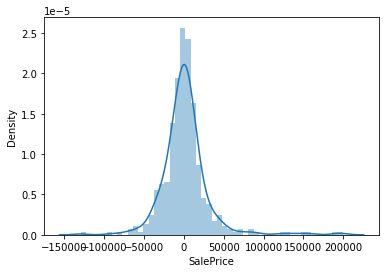

In [258]:
sns.distplot(residual)

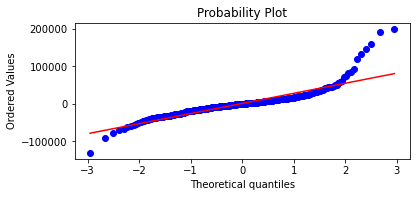

In [259]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

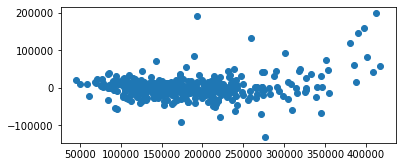

In [260]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred_test, residual)

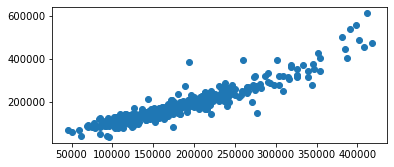

In [261]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred_test, y_test)

## Lasso

In [262]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 200, 300, 400, 500, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [263]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 300}


In [264]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =300

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=300)

In [265]:
lasso.coef_

array([ 0.00000000e+00,  3.86420894e+03,  2.01898541e+03,  4.37105991e+03,
        5.54833225e+02, -0.00000000e+00,  6.59681203e+03,  0.00000000e+00,
        3.20282241e+03, -2.03651445e+03,  2.88087475e+04,  2.26637301e+03,
        0.00000000e+00,  2.78268866e+03,  0.00000000e+00, -1.49715645e+03,
       -4.99310737e+03, -0.00000000e+00,  9.18565101e+02,  5.37159522e+03,
        0.00000000e+00,  3.22321959e+02,  7.02402076e+02, -0.00000000e+00,
        1.03654634e+03,  9.79144162e+02,  3.43249999e+02,  2.70902613e+00,
        0.00000000e+00,  2.84293156e+02,  1.51801149e+03, -0.00000000e+00,
        7.93780905e+02,  3.66931800e+02, -2.57793594e+02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.33264861e+03, -6.46127556e+02,
        1.77909788e+03, -9.27643986e+02,  0.00000000e+00, -0.00000000e+00,
        1.51848695e+02, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.83843563e+02,  7.24499246e+01,  3.99281101e+03,
       -2.86137656e+03,  

In [266]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

In [267]:
metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_train_lr:",r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_test_lr:",r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss_train_lr:",rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss_test_lr:",rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse_train_lr:",mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse_test_lr:",mse_test_lr)
metric3.append(mse_test_lr**0.5)

r2_train_lr: 0.9435633798486435
r2_test_lr: 0.8430243437160778
rss_train_lr: 360105074446.3039
rss_test_lr: 442469249327.45636
mse_train_lr: 352698407.8808069
mse_test_lr: 1010203765.5877999


## Residual Analysis for Lasso

In [268]:
residual = y_test - y_pred_test

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

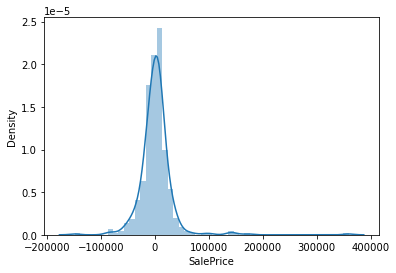

In [269]:
sns.distplot(residual)

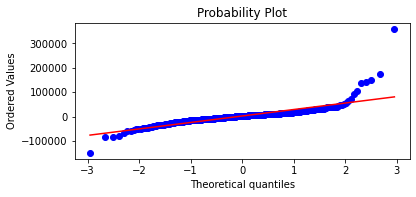

In [270]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

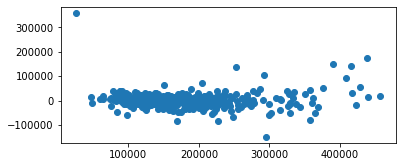

In [271]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred_test, residual)

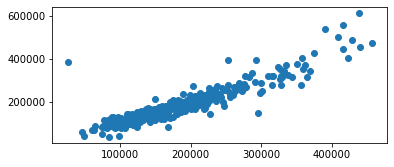

In [272]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred_test, y_test)

In [273]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       9.559656e-01      8.987957e-01      9.435634e-01
1   R2 Score (Test)      -1.226681e+22      8.621086e-01      8.430243e-01
2       RSS (Train)       2.809701e+11      6.457544e+11      3.601051e+11
3        RSS (Test)       3.457662e+34      3.886763e+11      4.424692e+11
4       MSE (Train)       1.658888e+04      2.514901e+04      1.878027e+04
5        MSE (Test)       8.884934e+15      2.978907e+04      3.178370e+04

## the changes in the coefficients after regularization

In [274]:
betas = pd.DataFrame(index=X.columns)

In [275]:
betas.rows = X.columns

In [276]:
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [277]:
pd.set_option('display.max_rows', None)
betas.head(50)

Linear        Ridge         Lasso
LotFrontage           9.009448e+02     6.595590      0.000000
LotArea               6.409706e+03  2884.067783   3864.208945
MasVnrArea            2.945587e+03  3306.280669   2018.985412
BsmtFinSF1            1.102822e+16  2052.860904   4371.059914
BsmtFinSF2            3.900617e+15   927.634293    554.833225
BsmtUnfSF             1.068412e+16   771.053987     -0.000000
TotalBsmtSF          -1.060767e+16  3251.965333   6596.812031
1stFlrSF              7.207449e+15  5299.549990      0.000000
2ndFlrSF              8.138532e+15  5269.855130   3202.822410
LowQualFinSF          9.065171e+14  -523.155036  -2036.514446
GrLivArea            -9.796930e+15  8228.176325  28808.747480
BsmtFullBath          8.657500e+02  2459.471452   2266.373011
BsmtHalfBath          7.537500e+01   245.762645      0.000000
FullBath              1.669000e+03  4471.037919   2782.688659
HalfBath             -9.155000e+02  2058.076221      0.000000
BedroomAbvGr         -1.515500e+03   542.223729  -1497.156450
KitchenAbvGr         -4.410188e+03 -2028.208227  -4993.107371
TotRmsAbvGrd         -1.641750e+03  3899.017227     -0.000000
Fireplaces            1.589750e+03  2590.735228    918.565101
GarageCars            2.702219e+03  4709.206839   5371.595218
GarageArea            2.799250e+03  2932.166619      0.000000
WoodDeckSF            5.562500e+02  1452.417358    322.321959
OpenPorchSF           1.685469e+03   951.878983    702.402076
EnclosedPorch         4.200000e+01    95.947964     -0.000000
3SsnPorch             1.263625e+03  1222.980273   1036.546344
ScreenPorch           1.225000e+03  1318.311063    979.144162
PoolArea              3.851375e+03  -316.010959    343.249999
MiscVal               7.187500e+02   185.639455      2.709026
MSZoning_FV           8.150000e+03   834.952758      0.000000
MSZoning_RH           4.795125e+03   382.748775    284.293156
MSZoning_RL           1.723744e+04  1241.521248   1518.011489
MSZoning_RM           1.399912e+04  -690.630146     -0.000000
Street_Pave           1.128938e+03   724.195564    793.780905
LotShape_IR2          5.970000e+02   534.245413    366.931800
LotShape_IR3          7.197500e+02 -2105.493630   -257.793594
LotShape_Reg          4.450000e+01  -350.979842     -0.000000
LandContour_HLS      -4.505000e+02  1083.700168      0.000000
LandContour_Low      -1.092000e+03   614.407868      0.000000
LandContour_Lvl       1.058000e+03  1851.042610   1332.648614
Utilities_NoSeWa     -4.435000e+02  -985.925678   -646.127556
LotConfig_CulDSac     1.669000e+03  2040.569945   1779.097879
LotConfig_FR2        -1.383562e+03 -1213.852281   -927.643986
LotConfig_FR3         4.659219e+02  -296.943609      0.000000
LotConfig_Inside     -4.315000e+02  -532.667942     -0.000000
LandSlope_Mod         7.210000e+02   735.406431    151.848695
LandSlope_Sev        -2.551500e+03   237.596395     -0.000000
Neighborhood_Blueste  3.569688e+02  -133.609724     -0.000000
Neighborhood_BrDale   3.921250e+02  -108.437356      0.000000
Neighborhood_BrkSide  4.860000e+02   203.982556      0.000000
Neighborhood_ClearCr -1.750000e+02   589.746229    583.843563

In [278]:
betas['Lasso'].sort_values(ascending=False)

RoofMatl_CompShg             5.747042e+04
RoofMatl_Tar&Grv             3.690913e+04
RoofMatl_WdShngl             3.162959e+04
GrLivArea                    2.880875e+04
RoofMatl_WdShake             2.424510e+04
OverallQual_10               1.259055e+04
RoofMatl_Membran             1.200591e+04
OverallQual_9                1.172173e+04
RoofMatl_Metal               1.142246e+04
RoofMatl_Roll                1.122430e+04
OverallQual_8                9.357789e+03
TotalBsmtSF                  6.596812e+03
SaleType_New                 5.756740e+03
GarageCars                   5.371595e+03
Neighborhood_NoRidge         4.827507e+03
BsmtFinSF1                   4.371060e+03
BsmtExposure_Gd              4.053729e+03
Neighborhood_Crawfor         3.992811e+03
LotArea                      3.864209e+03
Functional_Typ               3.411740e+03
Neighborhood_Somerst         3.241823e+03
Neighborhood_NridgHt         3.218834e+03
OverallQual_7                3.212860e+03
2ndFlrSF                     3.202

## Interpretation from the Lasso Model

1. The Lasso Model explains that, when the house is having below Roof material,the Saleprice is expected to grow:    


    CompShg	Standard (Composite) Shingle
    Tar&Grv	Gravel & Tar
    WdShake	Wood Shakes
    WdShngl	Wood Shingles
    
    
2. Also *GrLivArea* - Above grade (ground) living area square fee is propotinal to increase in Salesprice

3. And offcourse when the *OverallQual* overall material and finish of the house used is "very excellent", the saleprice can be higher.


4. The model also says that when the house is location in *Condition2_PosN*- Near positive off-site feature--park, greenbelt, etc, saleprice is expected to reduce.

5. When the height of basement and kitchen built quality is TYPICAL/AVERAGE , the Salesprice is expected to reduce

In [279]:
#further checking on multicollinearity

### VIF calculation
# Create a df that will contain the names of all the features and thier respect VIS values
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

Features     VIF
280              OverallCond_9     inf
263              MSSubClass_90     inf
249      SaleCondition_Partial     inf
242               SaleType_New     inf
234              GarageCond_TA     inf
233              GarageCond_Po     inf
232              GarageCond_NA     inf
231              GarageCond_Gd     inf
230              GarageCond_Fa     inf
229              GarageQual_TA     inf
228              GarageQual_Po     inf
227              GarageQual_NA     inf
226              GarageQual_Gd     inf
225              GarageQual_Fa     inf
222            GarageFinish_NA     inf
219             GarageYrBlt_NA     inf
217              GarageType_NA     inf
174            BsmtFinType1_NA     inf
165                BsmtCond_Po     inf
164                BsmtCond_NA     inf
161                BsmtQual_NA     inf
131         Exterior2nd_CBlock     inf
128        Exterior2nd_AsphShn     inf
117         Exterior1st_CBlock     inf
114        Exterior1st_AsphShn     inf
85             BldgType_2fmCon     inf
252             MSSubClass_190     inf
264             OverallQual_10     inf
277              OverallCond_6     inf
279              OverallCond_8     inf
3                   BsmtFinSF1     inf
4                   BsmtFinSF2     inf
5                    BsmtUnfSF     inf
6                  TotalBsmtSF     inf
7                     1stFlrSF     inf
8                     2ndFlrSF     inf
9                 LowQualFinSF     inf
10                   GrLivArea     inf
265              OverallQual_2     inf
278              OverallCond_7     inf
276              OverallCond_5     inf
275              OverallCond_4     inf
274              OverallCond_3     inf
273              OverallCond_2     inf
272              OverallQual_9     inf
271              OverallQual_8     inf
270              OverallQual_7     inf
269              OverallQual_6     inf
268              OverallQual_5     inf
267              OverallQual_4     inf
266              OverallQual_3     inf
86             BldgType_Duplex     inf
212          GarageType_Attchd  149.06
153               ExterCond_TA  141.94
102            RoofStyle_Gable  140.00
140        Exterior2nd_VinylSd  135.31
125        Exterior1st_VinylSd  132.46
104              RoofStyle_Hip  130.93
151               ExterCond_Gd  121.77
216          GarageType_Detchd  121.10
253              MSSubClass_20  111.66
135        Exterior2nd_MetalSd  110.44
121        Exterior1st_MetalSd  110.17
258              MSSubClass_60   99.20
119        Exterior1st_HdBoard   78.70
133        Exterior2nd_HdBoard   76.50
141        Exterior2nd_Wd Sdng   69.05
126        Exterior1st_Wd Sdng   68.27
30                 MSZoning_RL   60.37
257              MSSubClass_50   60.18
90           HouseStyle_1Story   52.87
107           RoofMatl_CompShg   52.18
137        Exterior2nd_Plywood   51.21
132        Exterior2nd_CmentBd   44.19
118        Exterior1st_CemntBd   43.62
261              MSSubClass_80   42.17
31                 MSZoning_RM   41.39
122        Exterior1st_Plywood   39.41
180            BsmtFinType2_NA   38.55
214         GarageType_BuiltIn   38.27
145            MasVnrType_None   37.13
93           HouseStyle_2Story   36.08
88             BldgType_TwnhsE   35.14
183               Heating_GasA   34.78
97         YearBuilt_from_2000   34.75
143         MasVnrType_BrkFace   32.71
169            BsmtExposure_NA   30.65
209             FireplaceQu_NA   27.83
95             HouseStyle_SLvl   27.34
259              MSSubClass_70   26.14
149               ExterQual_TA   25.15
220      GarageYrBlt_from_2000   24.65
57          Neighborhood_NAmes   24.65
150               ExterCond_Fa   24.32
111           RoofMatl_Tar&Grv   22.56
256              MSSubClass_45   22.33
254              MSSubClass_30   22.27
184               Heating_GasW   21.76
89           HouseStyle_1.5Unf   20.56
182           BsmtFinType2_Unf   20.34
148               ExterQual_Gd   20.19
28                 MSZoning_FV   19.64
62   

### Build model using RFE

In [280]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [281]:
lm_rfe = LinearRegression()
lm_rfe.fit(X_train,y_train)

LinearRegression()

In [282]:
#RFE with 15 features - R2 -> .179 
#RFE with 25 features - R2 -> .32
#RFE with 55 features

rfe1 = RFE(lm_rfe, n_features_to_select=55)

rfe1.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=55)

In [283]:
list(zip(X_train.columns,rfe1.support_,rfe1.ranking_))

[('LotFrontage', False, 71),
 ('LotArea', False, 18),
 ('MasVnrArea', False, 42),
 ('BsmtFinSF1', False, 8),
 ('BsmtFinSF2', False, 10),
 ('BsmtUnfSF', False, 11),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 139),
 ('BsmtHalfBath', False, 219),
 ('FullBath', False, 51),
 ('HalfBath', False, 152),
 ('BedroomAbvGr', False, 40),
 ('KitchenAbvGr', False, 13),
 ('TotRmsAbvGrd', False, 92),
 ('Fireplaces', False, 65),
 ('GarageCars', False, 12),
 ('GarageArea', False, 55),
 ('WoodDeckSF', False, 166),
 ('OpenPorchSF', False, 83),
 ('EnclosedPorch', False, 225),
 ('3SsnPorch', False, 108),
 ('ScreenPorch', False, 127),
 ('PoolArea', False, 38),
 ('MiscVal', False, 148),
 ('MSZoning_FV', False, 30),
 ('MSZoning_RH', False, 33),
 ('MSZoning_RL', False, 31),
 ('MSZoning_RM', False, 32),
 ('Street_Pave', False, 101),
 ('LotShape_IR2', False, 155),
 ('LotShape_IR3', False, 150),
 ('LotShape

In [284]:
X_train.columns[rfe1.support_]

Index(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BldgType_2fmCon', 'BldgType_Duplex', 'RoofMatl_CompShg',
       'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_CBlock',
       'Exterior2nd_AsphShn', 'Exterior2nd_CBlock', 'Exterior2nd_Other',
       'ExterCond_Po', 'BsmtQual_NA', 'BsmtCond_NA', 'BsmtCond_Po',
       'BsmtFinType1_NA', 'Electrical_Mix', 'Electrical_NA', 'GarageType_NA',
       'GarageYrBlt_NA', 'GarageFinish_NA', 'GarageQual_Fa', 'GarageQual_Gd',
       'GarageQual_NA', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Fa',
       'GarageCond_Gd', 'GarageCond_NA', 'GarageCond_Po', 'GarageCond_TA',
       'SaleType_New', 'SaleCondition_Partial', 'MSSubClass_190',
       'MSSubClass_90', 'OverallQual_10', 'OverallQual_2', 'OverallQual_3',
       'OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7',
       'OverallQual_8', 'OverallQual_9', 'OverallCond_2', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_5', 'Overall

In [285]:
import statsmodels.api as sm 

# 55 features selected by rfe1
col1 = X_train.columns[rfe1.support_]

#subsetting training data to these 55 features
X_train_rfe1 = X_train[col1]

X_train_rfe1 = sm.add_constant(X_train_rfe1)
#X_train_rfe1.head()
lm_rfe1 = sm.OLS(y_train,X_train_rfe1).fit()
lm_rfe1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     106.1
Date:                Thu, 29 Sep 2022   Prob (F-statistic):          7.08e-310
Time:                        02:55:35   Log-Likelihood:                -12154.
No. Observations:                1021   AIC:                         2.438e+04
Df Residuals:                     984   BIC:                         2.456e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
TotalBsmtSF            8946.0819   2780.416      3.218      0.001    3489.854    1.44e+04
1stFlrSF               1.136e+04   1891.335      6.006      0.000    7647.731    1.51e+04
2ndFlrSF               8584.3303   1110.399      7.731      0.000    6405.308    1.08e+04
LowQualFinSF          -3728.5473   1217.788     -3.062      0.002   -6118.307   -1338.788
GrLivArea              1.514e+04   1018.638     14.866      0.000    1.31e+04    1.71e+04
BldgType_2fmCon       -1.265e+05    984.818   -128.456      0.000   -1.28e+05   -1.25e+05
BldgType_Duplex       -1600.9936    612.510     -2.614      0.009   -2802.970    -399.017
RoofMatl_CompShg       4467.2090   1337.835      3.339      0.001    1841.871    7092.547
RoofMatl_WdShngl       8293.6606   1338.126      6.198      0.000    5667.752    1.09e+04
Exterior1st_AsphShn    6.808e+05   4395.607    154.876      0.000    6.72e+05    6.89e+05
Exterior1st_CBlock     -410.3560    481.729     -0.852      0.395   -1355.690     534.978
Exterior2nd_AsphShn   -1.179e+06   7501.586   -157.160      0.000   -1.19e+06   -1.16e+06
Exterior2nd_CBlock     -410.3560    481.729     -0.852      0.395   -1355.690     534.978
Exterior2nd_Other     -1.361e+06   8647.595   -157.349      0.000   -1.38e+06   -1.34e+06
ExterCond_Po          -1.361e+06   8647.595   -157.349      0.000   -1.38e+06   -1.34e+06
BsmtQual_NA              89.8461    539.065      0.167      0.868    -968.003    1147.696
BsmtCond_NA              89.8461    539.065      0.167      0.868    -968.003    1147.696
BsmtCond_Po           -4565.2103   1359.469     -3.358      0.001   -7233.002   -1897.419
BsmtFinType1_NA          89.8461    539.065      0.167      0.868    -968.003    1147.696
Electrical_Mix        -1.361e+06   8647.595   -157.349      0.000   -1.38e+06   -1.34e+06
Electrical_NA         -1.361e+06   8647.595   -157.349      0.000   -1.38e+06   -1.34e+06
GarageType_NA          -723.0344   1695.018     -0.427      0.670   -4049.300    2603.231
GarageYrBlt_NA         -723.0344   1695.018     -0.427      0.670   -4049.300    2603.231
GarageFinish_NA        -723.0344   1695.018     -0.427      0.670   -4049.300    2603.231
GarageQual_Fa          2.134e+04   3262.992      6.540      0.000    1.49e+04    2.77e+04
GarageQual_Gd          1.384e+04   2066.516      6.697      0.000    9785.199    1.79e+04
GarageQual_NA          -723.0344   1695.018     -0.427      0.670   -4049.300    2603.231
GarageQual_Po          6058.8338   1713.054      3.537      0.000    2697.175    9420.493
GarageQual_TA          4.338e+04   5203.208      8.338      0.000    3.32e+04    5.36e+04
GarageCond_Fa         -2.269e+04   3216.565     -7.054      0.000    -2.9e+04   -1.64e+04
GarageCond_Gd         -1.149e+04   1951.653     -5.886      0.000   -1.53e+04   -7658.030
GarageCond_NA          

## After Doubling the alpha value for Ridge and Lasso :

#### `Ridge

In [286]:

#optimal alpha = 400
alpha = 400*2
ridge_doub = Ridge(alpha=alpha)

ridge_doub.fit(X_train, y_train)
print(ridge_doub.coef_)

[ 4.97556238e+02  2.42856647e+03  3.29542912e+03  2.32523902e+03
  7.24301414e+02  8.44464600e+02  3.53431283e+03  4.84041840e+03
  3.96658736e+03 -3.61036181e+02  6.82274734e+03  2.10706996e+03
  1.72853767e+02  3.82645512e+03  1.97986288e+03  8.17940951e+02
 -1.57258282e+03  3.89647143e+03  2.81158456e+03  4.01965442e+03
  3.24334560e+03  1.69885058e+03  1.04783537e+03  6.14352071e+01
  1.01336599e+03  1.09760967e+03  2.59624834e+00  1.24283937e+02
  7.05194545e+02  2.42933066e+02  1.10280692e+03 -1.00933975e+03
  5.79750887e+02  5.54600915e+02 -1.68547650e+03 -6.94360066e+02
  9.11583341e+02  5.45995775e+02  1.12043902e+03 -8.04290008e+02
  1.76145700e+03 -9.00125292e+02 -2.37646120e+02 -4.87182016e+02
  6.20724769e+02  2.07825356e+02 -7.45719760e+01 -2.11095643e+02
  2.06282222e+02  5.15696854e+02 -8.73641043e+02  2.55009060e+03
 -2.63037432e+03 -1.06350432e+03 -7.78585443e+02 -1.17480487e+03
 -1.20445077e+03 -1.46066128e+03 -7.56052817e+01 -3.85358715e+02
  5.27314784e+03  4.07643

In [287]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge_doub.predict(X_train)
y_pred_test = ridge_doub.predict(X_test)

In [288]:
metric2_doub = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_train_lr:",r2_train_lr)
metric2_doub.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_test_lr:",r2_test_lr)
metric2_doub.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss_train_lr:",rss1_lr)
metric2_doub.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss_test_lr:",rss2_lr)
metric2_doub.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse_train_lr:",mse_train_lr)
metric2_doub.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse_test_lr:",mse_test_lr)
metric2_doub.append(mse_test_lr**0.5)

r2_train_lr: 0.8783104291403658
r2_test_lr: 0.8552821773815448
rss_train_lr: 776464498692.9474
rss_test_lr: 407917939979.6548
mse_train_lr: 760494122.128254
mse_test_lr: 931319497.6704447


In [289]:
# For ridge with alpha = 400 :
#r2_train_lr: 0.8987956577054865
#r2_test_lr: 0.8621085530474578
#rss_train_lr: 645754425380.4685
#rss_test_lr: 388676349353.267
 
# So with alpha = 400*2 -> r2 has reduced a little bit and rss(error terms) has increased

#### Lasso

In [290]:
#Fitting Lasso model for alpha = 300*2 and printing coefficients which have been penalised
#optimal alpha for lasso  =300
alpha = 300*2
lasso_doub = Lasso(alpha=alpha)
        
lasso_doub.fit(X_train, y_train) 
print(lasso_doub.coef_)

[-0.00000000e+00  3.38243414e+03  1.30981895e+03  1.45989216e+03
  0.00000000e+00 -0.00000000e+00  2.31563931e+03  0.00000000e+00
  0.00000000e+00 -2.00382123e+03  2.93965944e+04  3.06045458e+03
  9.88591195e+00  3.21379832e+03  4.09696745e+02 -4.89326740e+02
 -4.59457007e+03  0.00000000e+00  2.19473806e+02  6.59411349e+03
  0.00000000e+00  3.34858579e+02  1.23628353e+01 -0.00000000e+00
  8.96480829e+02  1.09807132e+03 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.26513478e+03 -0.00000000e+00
  4.35972394e+02  4.14011269e+02 -1.18942585e+03 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.22096701e+03 -7.92064535e+02
  2.18941841e+03 -4.19963422e+02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.29328812e+03  0.00000000e+00  4.06083355e+03
 -2.84250377e+03  0.00000000e+00 -6.17452322e+02 -1.25197262e+03
 -3.20583095e+02 -1.10105631e+03  0.00000000e+00 -0.00000000e+00
  5.35801093e+03  4.25187

In [291]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso_doub.predict(X_train)
y_pred_test = lasso_doub.predict(X_test)


In [292]:
metric3_doub = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_train_lr:",r2_train_lr)
metric3_doub.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_test_lr:",r2_test_lr)
metric3_doub.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss_train_lr:",rss1_lr)
metric3_doub.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss_test_lr:",rss2_lr)
metric3_doub.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse_train_lr:",mse_train_lr)
metric3_doub.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse_test_lr:",mse_test_lr)
metric3_doub.append(mse_test_lr**0.5)

r2_train_lr: 0.922543139474474
r2_test_lr: 0.8458919155123339
rss_train_lr: 494228896966.4865
rss_test_lr: 434386388773.67004
mse_train_lr: 484063562.16110337
mse_test_lr: 991749746.0586075


In [293]:
betas_2 = pd.DataFrame(index=X.columns)
betas_2.rows = X.columns
betas_2['ridge_doub'] = ridge_doub.coef_
betas_2['lasso_doub'] = lasso_doub.coef_

In [294]:
pd.set_option('display.max_rows', None)
betas_2.sort_values(by= ['lasso_doub'],ascending=False)

ridge_doub    lasso_doub
GrLivArea                  6.822747e+03  29396.594435
RoofMatl_CompShg           8.824541e+02  24759.786851
RoofMatl_WdShngl           4.043865e+03  15970.374825
RoofMatl_Tar&Grv           9.720100e+01  14243.678515
OverallQual_9              6.036691e+03  13077.585418
OverallQual_10             6.222225e+03  12591.525794
OverallQual_8              3.769225e+03  10286.671950
RoofMatl_WdShake           3.474311e+02   9961.489181
GarageCars                 4.019654e+03   6594.113493
Neighborhood_NoRidge       5.273148e+03   5358.010930
RoofMatl_Membran           5.991580e+02   5192.767113
SaleType_New               1.649520e+03   4935.715114
BsmtExposure_Gd            3.625422e+03   4704.098814
RoofMatl_Metal             1.301110e+02   4583.486614
RoofMatl_Roll              1.717285e+02   4539.173434
Neighborhood_NridgHt       4.076437e+03   4251.878191
Neighborhood_Crawfor       2.550091e+03   4060.833554
MSSubClass_20              1.171309e+03   3800.635550
LotArea                    2.428566e+03   3382.434140
FullBath                   3.826455e+03   3213.798320
OverallQual_7             -4.411290e+02   3198.532957
Neighborhood_Somerst       1.468816e+03   3094.913416
BsmtFullBath               2.107070e+03   3060.454576
BsmtFinType1_GLQ           2.910926e+03   3009.277902
Functional_Typ             1.198431e+03   2767.051808
Condition1_Norm            1.744341e+03   2683.984428
Exterior1st_BrkFace        1.588349e+03   2621.439191
TotalBsmtSF                3.534313e+03   2315.639310
LotConfig_CulDSac          1.761457e+03   2189.418407
Exterior2nd_VinylSd        7.598133e+02   1829.950429
BsmtFinSF1                 2.325239e+03   1459.892155
OverallCond_9              1.499251e+03   1421.994350
MasVnrArea                 3.295429e+03   1309.818948
Neighborhood_ClearCr       5.156969e+02   1293.288117
MSZoning_RL                1.102807e+03   1265.134778
YearRemodAdd_from_2000     1.483903e+03   1255.574854
OverallCond_7              1.192422e+03   1252.834582
LandContour_Lvl            1.120439e+03   1220.967008
Foundation_PConc           1.408166e+03   1187.644255
ScreenPorch                1.097610e+03   1098.071322
BsmtCond_TA                6.444184e+02   1020.667567
Exterior2nd_ImStucc        1.710402e+03   1004.239369
OverallCond_8              7.732980e+02    983.362819
CentralAir_Y               1.040180e+03    927.020219
3SsnPorch                  1.013366e+03    896.480829
Exterior2nd_CmentBd        9.613168e+02    881.050771
Neighborhood_StoneBr       1.465239e+03    720.777481
SaleType_Con               6.499432e+02    667.136164
HouseStyle_1.5Unf          2.358317e+02    629.073170
Neighborhood_Veenker       9.319409e+02    613.859759
Condition1_PosA            8.037234e+02    543.695074
Street_Pave                5.797509e+02    435.972394
Heating_GasW               6.220955e+02    429.769103
Condition1_RRAn            5.850451e+02    426.634363
LotShape_IR2               5.546009e+02    414.011269
HalfBath                   1.979863e+03    409.696745
WoodDeckSF                 1.698851e+03    334.858579
Condition2_Norm            1.471035e+03    317.965878
RoofStyle_Shed             5.806486e+02    280.293221
RoofStyle_Mansard          3.326357e+02    275.074866
Fireplaces                 2.811585e+03    219.473806
SaleCondition_Normal       5.051918e+01    114.290438
MSSubClass_40              1.505375e+02     90.922321
Neighborhood_SawyerW      -1.452325e+02     88.034773
GarageQual_Gd              1.051195e+03     55.735008
YearRemodAdd_1973_to_2000  1.064316e+03     49.819018
BsmtFinType2_GLQ           3.647127e+02     38.384905
PavedDrive_Y               4.699338e+02     17.928207
OpenPorchSF                1.047835e+03     12.362835
BsmtHalfBath               1.728538e+02      9.885912
Condition2_RRNn            4.812293e+02      3.252825
Functional_Min1           -2.346535e+02      0.000000
Functional_Maj2           -5.602613e+02     -0.000000
ExterCond_TA               6.3661

In [295]:
pd.set_option('display.max_rows', None)
betas_2.sort_values(by= ['ridge_doub'],ascending=False)

ridge_doub    lasso_doub
GrLivArea                  6.822747e+03  29396.594435
OverallQual_10             6.222225e+03  12591.525794
OverallQual_9              6.036691e+03  13077.585418
Neighborhood_NoRidge       5.273148e+03   5358.010930
1stFlrSF                   4.840418e+03      0.000000
Neighborhood_NridgHt       4.076437e+03   4251.878191
RoofMatl_WdShngl           4.043865e+03  15970.374825
GarageCars                 4.019654e+03   6594.113493
2ndFlrSF                   3.966587e+03      0.000000
TotRmsAbvGrd               3.896471e+03      0.000000
FullBath                   3.826455e+03   3213.798320
OverallQual_8              3.769225e+03  10286.671950
BsmtExposure_Gd            3.625422e+03   4704.098814
TotalBsmtSF                3.534313e+03   2315.639310
MasVnrArea                 3.295429e+03   1309.818948
GarageArea                 3.243346e+03      0.000000
BsmtFinType1_GLQ           2.910926e+03   3009.277902
Fireplaces                 2.811585e+03    219.473806
Neighborhood_Crawfor       2.550091e+03   4060.833554
LotArea                    2.428566e+03   3382.434140
BsmtFinSF1                 2.325239e+03   1459.892155
BsmtFullBath               2.107070e+03   3060.454576
HalfBath                   1.979863e+03    409.696745
LotConfig_CulDSac          1.761457e+03   2189.418407
Condition1_Norm            1.744341e+03   2683.984428
Exterior2nd_ImStucc        1.710402e+03   1004.239369
WoodDeckSF                 1.698851e+03    334.858579
SaleType_New               1.649520e+03   4935.715114
SaleCondition_Partial      1.631436e+03      0.000000
Exterior1st_BrkFace        1.588349e+03   2621.439191
OverallCond_9              1.499251e+03   1421.994350
YearRemodAdd_from_2000     1.483903e+03   1255.574854
Condition2_Norm            1.471035e+03    317.965878
Neighborhood_Somerst       1.468816e+03   3094.913416
Neighborhood_StoneBr       1.465239e+03    720.777481
Foundation_PConc           1.408166e+03   1187.644255
Functional_Typ             1.198431e+03   2767.051808
OverallCond_7              1.192422e+03   1252.834582
MSSubClass_20              1.171309e+03   3800.635550
LandContour_Lvl            1.120439e+03   1220.967008
MSZoning_RL                1.102807e+03   1265.134778
ScreenPorch                1.097610e+03   1098.071322
MSSubClass_60              1.088281e+03      0.000000
YearBuilt_from_2000        1.067795e+03      0.000000
YearRemodAdd_1973_to_2000  1.064316e+03     49.819018
GarageQual_Gd              1.051195e+03     55.735008
OpenPorchSF                1.047835e+03     12.362835
CentralAir_Y               1.040180e+03    927.020219
GarageType_BuiltIn         1.030772e+03      0.000000
FireplaceQu_Gd             1.021665e+03      0.000000
RoofStyle_Hip              1.018668e+03      0.000000
3SsnPorch                  1.013366e+03    896.480829
Exterior2nd_CmentBd        9.613168e+02    881.050771
Neighborhood_Veenker       9.319409e+02    613.859759
LandContour_HLS            9.115833e+02      0.000000
ExterQual_Gd               9.081785e+02      0.000000
RoofMatl_CompShg           8.824541e+02  24759.786851
GarageYrBlt_from_2000      8.755141e+02      0.000000
BsmtUnfSF                  8.444646e+02     -0.000000
BedroomAbvGr               8.179410e+02   -489.326740
Condition1_PosA            8.037234e+02    543.695074
OverallCond_8              7.732980e+02    983.362819
Exterior2nd_VinylSd        7.598133e+02   1829.950429
MSSubClass_70              7.457521e+02     -0.000000
BsmtFinSF2                 7.243014e+02      0.000000
Condition2_PosA            7.236076e+02    -71.710830
MSZoning_FV                7.051945e+02      0.000000
GarageType_Attchd          7.024207e+02      0.000000
SaleType_Con               6.499432e+02    667.136164
BsmtCond_TA                6.444184e+02   1020.667567
HouseStyle_2Story          6.419730e+02     -0.000000
Heating_GasW               6.220955e+02    429.769103
YearBuilt_1973_to_2000     6.216385e+02      0.000000
LandSlope_Mod              6.2072

## After removing 5 important predictor variable from Lasso 


    RoofMatl_CompShg             5.747042e+04
    RoofMatl_Tar&Grv             3.690913e+04
    RoofMatl_WdShngl             3.162959e+04
    GrLivArea                    2.880875e+04
    RoofMatl_WdShake             2.424510e+04



In [296]:
imp_lasso_vars = ['RoofMatl_CompShg','RoofMatl_Tar&Grv','RoofMatl_WdShngl','GrLivArea','RoofMatl_WdShake']

In [297]:
X_train_las = X_train.drop(imp_lasso_vars,axis=1)

alpha = 300
lasso_5pred = Lasso(alpha=alpha)
        
lasso_5pred.fit(X_train_las, y_train) 
print(lasso_5pred.coef_)

[-7.85497931e+02  4.70801200e+03  1.70304735e+03 -0.00000000e+00
  1.54377899e+02  0.00000000e+00  9.07883895e+02  1.80580541e+04
  2.64759004e+04  2.61401179e+02  3.59452170e+03  4.40932447e+02
  4.38427771e+03  6.56013647e+02 -2.44222287e+02 -3.81488060e+03
  0.00000000e+00  0.00000000e+00  7.91443348e+03 -4.69932813e+02
  7.38068215e+02  0.00000000e+00  0.00000000e+00  1.23184901e+03
  1.08738578e+03 -2.06912709e+03  0.00000000e+00  0.00000000e+00
  2.52587537e+02  1.15637695e+03 -0.00000000e+00  9.03368407e+02
  3.08483566e+02 -2.82222249e+03 -0.00000000e+00  2.90315142e+02
  1.04819869e+03  2.51721479e+03 -9.52350278e+02  1.84181190e+03
 -1.53401471e+03 -0.00000000e+00 -0.00000000e+00  2.46449700e+02
 -9.15533425e+01 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.06681038e+03  4.13507384e+00  4.87911957e+03 -3.61035932e+03
  0.00000000e+00 -9.23431288e+02 -2.00614069e+03 -1.31424970e+03
 -1.27289638e+03  0.00000000e+00 -2.06115787e+01  6.48382429e+03
  4.53688513e+03 -2.06471

In [298]:
betas_1 = pd.DataFrame(index=X_train_las.columns)
betas_1.rows = X_train_las.columns

betas_1['Lasso_5pred'] = lasso_5pred.coef_

In [299]:
betas_1['Lasso_5pred'].sort_values(ascending=False)

2ndFlrSF                     26475.900429
1stFlrSF                     18058.054093
OverallQual_9                12740.833673
OverallQual_10               12508.777842
OverallQual_8                10130.681219
GarageCars                    7914.433480
Neighborhood_NoRidge          6483.824288
Neighborhood_Crawfor          4879.119569
BsmtExposure_Gd               4777.397707
LotArea                       4708.012002
SaleType_New                  4619.241477
Neighborhood_NridgHt          4536.885132
FullBath                      4384.277715
MSSubClass_20                 4252.393517
OverallQual_7                 3767.776427
BsmtFullBath                  3594.521705
Neighborhood_Somerst          3586.935488
Exterior1st_BrkFace           2822.726582
Condition1_Norm               2807.950586
BsmtFinType1_GLQ              2728.773628
ExterQual_Gd                  2643.511363
LandContour_Lvl               2517.214793
HouseStyle_1Story             2485.532942
Functional_Typ                2343